# Лабораторная работа №3. Обучение с учителем

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: Забашта Алексей.

## Инициализация

### Импорт библиотек

In [1]:
import pandas
import numpy
import matplotlib.pyplot
import warnings
import seaborn
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import copy

In [2]:
warnings.filterwarnings("ignore")

In [3]:
matplotlib.rcParams.update({'font.size': 17})

#### Установка константных значений

In [4]:
PLT_FIGSIZE = (26, 18)
PLT_FIGSIZE_SMALL = (PLT_FIGSIZE[0] // 2, PLT_FIGSIZE[1] // 2)
TARGET_PREDICT = "Цена"
FUNC_ERROR = sklearn.metrics.mean_squared_error
FEATURES_RU_TEXT = ["Бренд", "Цвет арматуры", "Цвет плафонов", "Стиль", "Цоколь"]
FEATURES_RU_NUMERIC = ["Цена", "Напряжение, В", "Диаметр", "Высота", "Количество ламп", "Мощность, Вт", "Общая мощность, Вт"]
FEATURES_RU_ALL = FEATURES_RU_TEXT + FEATURES_RU_NUMERIC
FEATURES_EN_TEXT = ["brand", "color_reinforcement", "color_shade", "style", "plinth"]
FEATURES_EN_NUMERIC = ["price", "voltage", "diameter", "height", "count_lamp", "power", "general_power"]
FEATURES_EN_ALL = FEATURES_EN_TEXT + FEATURES_EN_NUMERIC
FEATURES_EN_RU = dict(map(lambda i, j : (i, j) , FEATURES_EN_ALL, FEATURES_RU_ALL))
FEATURES_RU_EN = dict(map(lambda i, j : (i, j) , FEATURES_RU_ALL, FEATURES_EN_ALL))
COLOR_SET_TRAIN = "red"
COLOR_SET_VALID = "green"
COLOR_SET_TEST = "blue"

### Загрузка данных

#### Чтение из `msveta.csv`

In [5]:
msveta = pandas.read_csv('msveta.csv', delimiter = ';')
msveta = msveta.drop(columns = ["Наименование"])

In [6]:
msveta.head()

,Цена,"Напряжение, В",Бренд,Диаметр,Высота,Цвет арматуры,Цвет плафонов,Количество ламп,"Мощность, Вт","Общая мощность, Вт",Стиль,Цоколь
0,79000,220,Lightstar,600.0,650.0,хром,прозрачный,15,60.0,900.0,классика,E14
1,54070,220,Mantra,1000.0,635.0,хром,белый,8,20.0,160.0,арт-деко,E14
2,38000,220,Osgona,750.0,1700.0,золото,белый,8,60.0,480.0,арт-деко,E14
3,24000,220,Lightstar,450.0,900.0,черный,черный,5,40.0,200.0,классика,E14
4,8900,220,Lightstar,400.0,770.0,латунь,белый,8,40.0,320.0,арт-деко,G9


In [7]:
msveta.tail()

,Цена,"Напряжение, В",Бренд,Диаметр,Высота,Цвет арматуры,Цвет плафонов,Количество ламп,"Мощность, Вт","Общая мощность, Вт",Стиль,Цоколь
26221,16650,220,Toplight,610.0,1250.0,бронза,голубой,5,40.0,200.0,модерн,E14
26222,16930,220,Toplight,580.0,150.0,хром,белый,5,40.0,200.0,классика,E14
26223,12990,220,Toplight,600.0,250.0,бронза,белый,5,40.0,200.0,модерн,E14
26224,8050,220,Toplight,640.0,200.0,белый,белый,5,60.0,300.0,прованс,E14
26225,16440,220,Toplight,580.0,1570.0,бронза,белый,5,40.0,200.0,классика,E14


#### Замена названий

In [8]:
msveta.rename(columns = FEATURES_RU_EN, inplace = True)

In [9]:
msveta.head()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
0,79000,220,Lightstar,600.0,650.0,хром,прозрачный,15,60.0,900.0,классика,E14
1,54070,220,Mantra,1000.0,635.0,хром,белый,8,20.0,160.0,арт-деко,E14
2,38000,220,Osgona,750.0,1700.0,золото,белый,8,60.0,480.0,арт-деко,E14
3,24000,220,Lightstar,450.0,900.0,черный,черный,5,40.0,200.0,классика,E14
4,8900,220,Lightstar,400.0,770.0,латунь,белый,8,40.0,320.0,арт-деко,G9


In [10]:
msveta.tail()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
26221,16650,220,Toplight,610.0,1250.0,бронза,голубой,5,40.0,200.0,модерн,E14
26222,16930,220,Toplight,580.0,150.0,хром,белый,5,40.0,200.0,классика,E14
26223,12990,220,Toplight,600.0,250.0,бронза,белый,5,40.0,200.0,модерн,E14
26224,8050,220,Toplight,640.0,200.0,белый,белый,5,60.0,300.0,прованс,E14
26225,16440,220,Toplight,580.0,1570.0,бронза,белый,5,40.0,200.0,классика,E14


## Обзор данных

### Вспомогательные функции

In [11]:
def draw_feature_countable(feature):
    matplotlib.pyplot.figure(figsize = PLT_FIGSIZE)
    matplotlib.pyplot.grid(True)
    seaborn.countplot(data = msveta, y = FEATURES_RU_EN[feature], order = msveta[FEATURES_RU_EN[feature]].value_counts().index)
    matplotlib.pyplot.xlabel("Количество")
    matplotlib.pyplot.ylabel(feature)

In [12]:
def print_feature_counts(feature):
    for f, c in msveta[FEATURES_RU_EN[feature]].value_counts().to_dict().items():
        print(f, c)

In [13]:
def remove_all_category_except(category, excepted):
    global msveta
    mask = msveta[FEATURES_RU_EN[category]].isin(excepted)
    msveta = msveta[mask]

### Категориальные переменные

#### Бренд

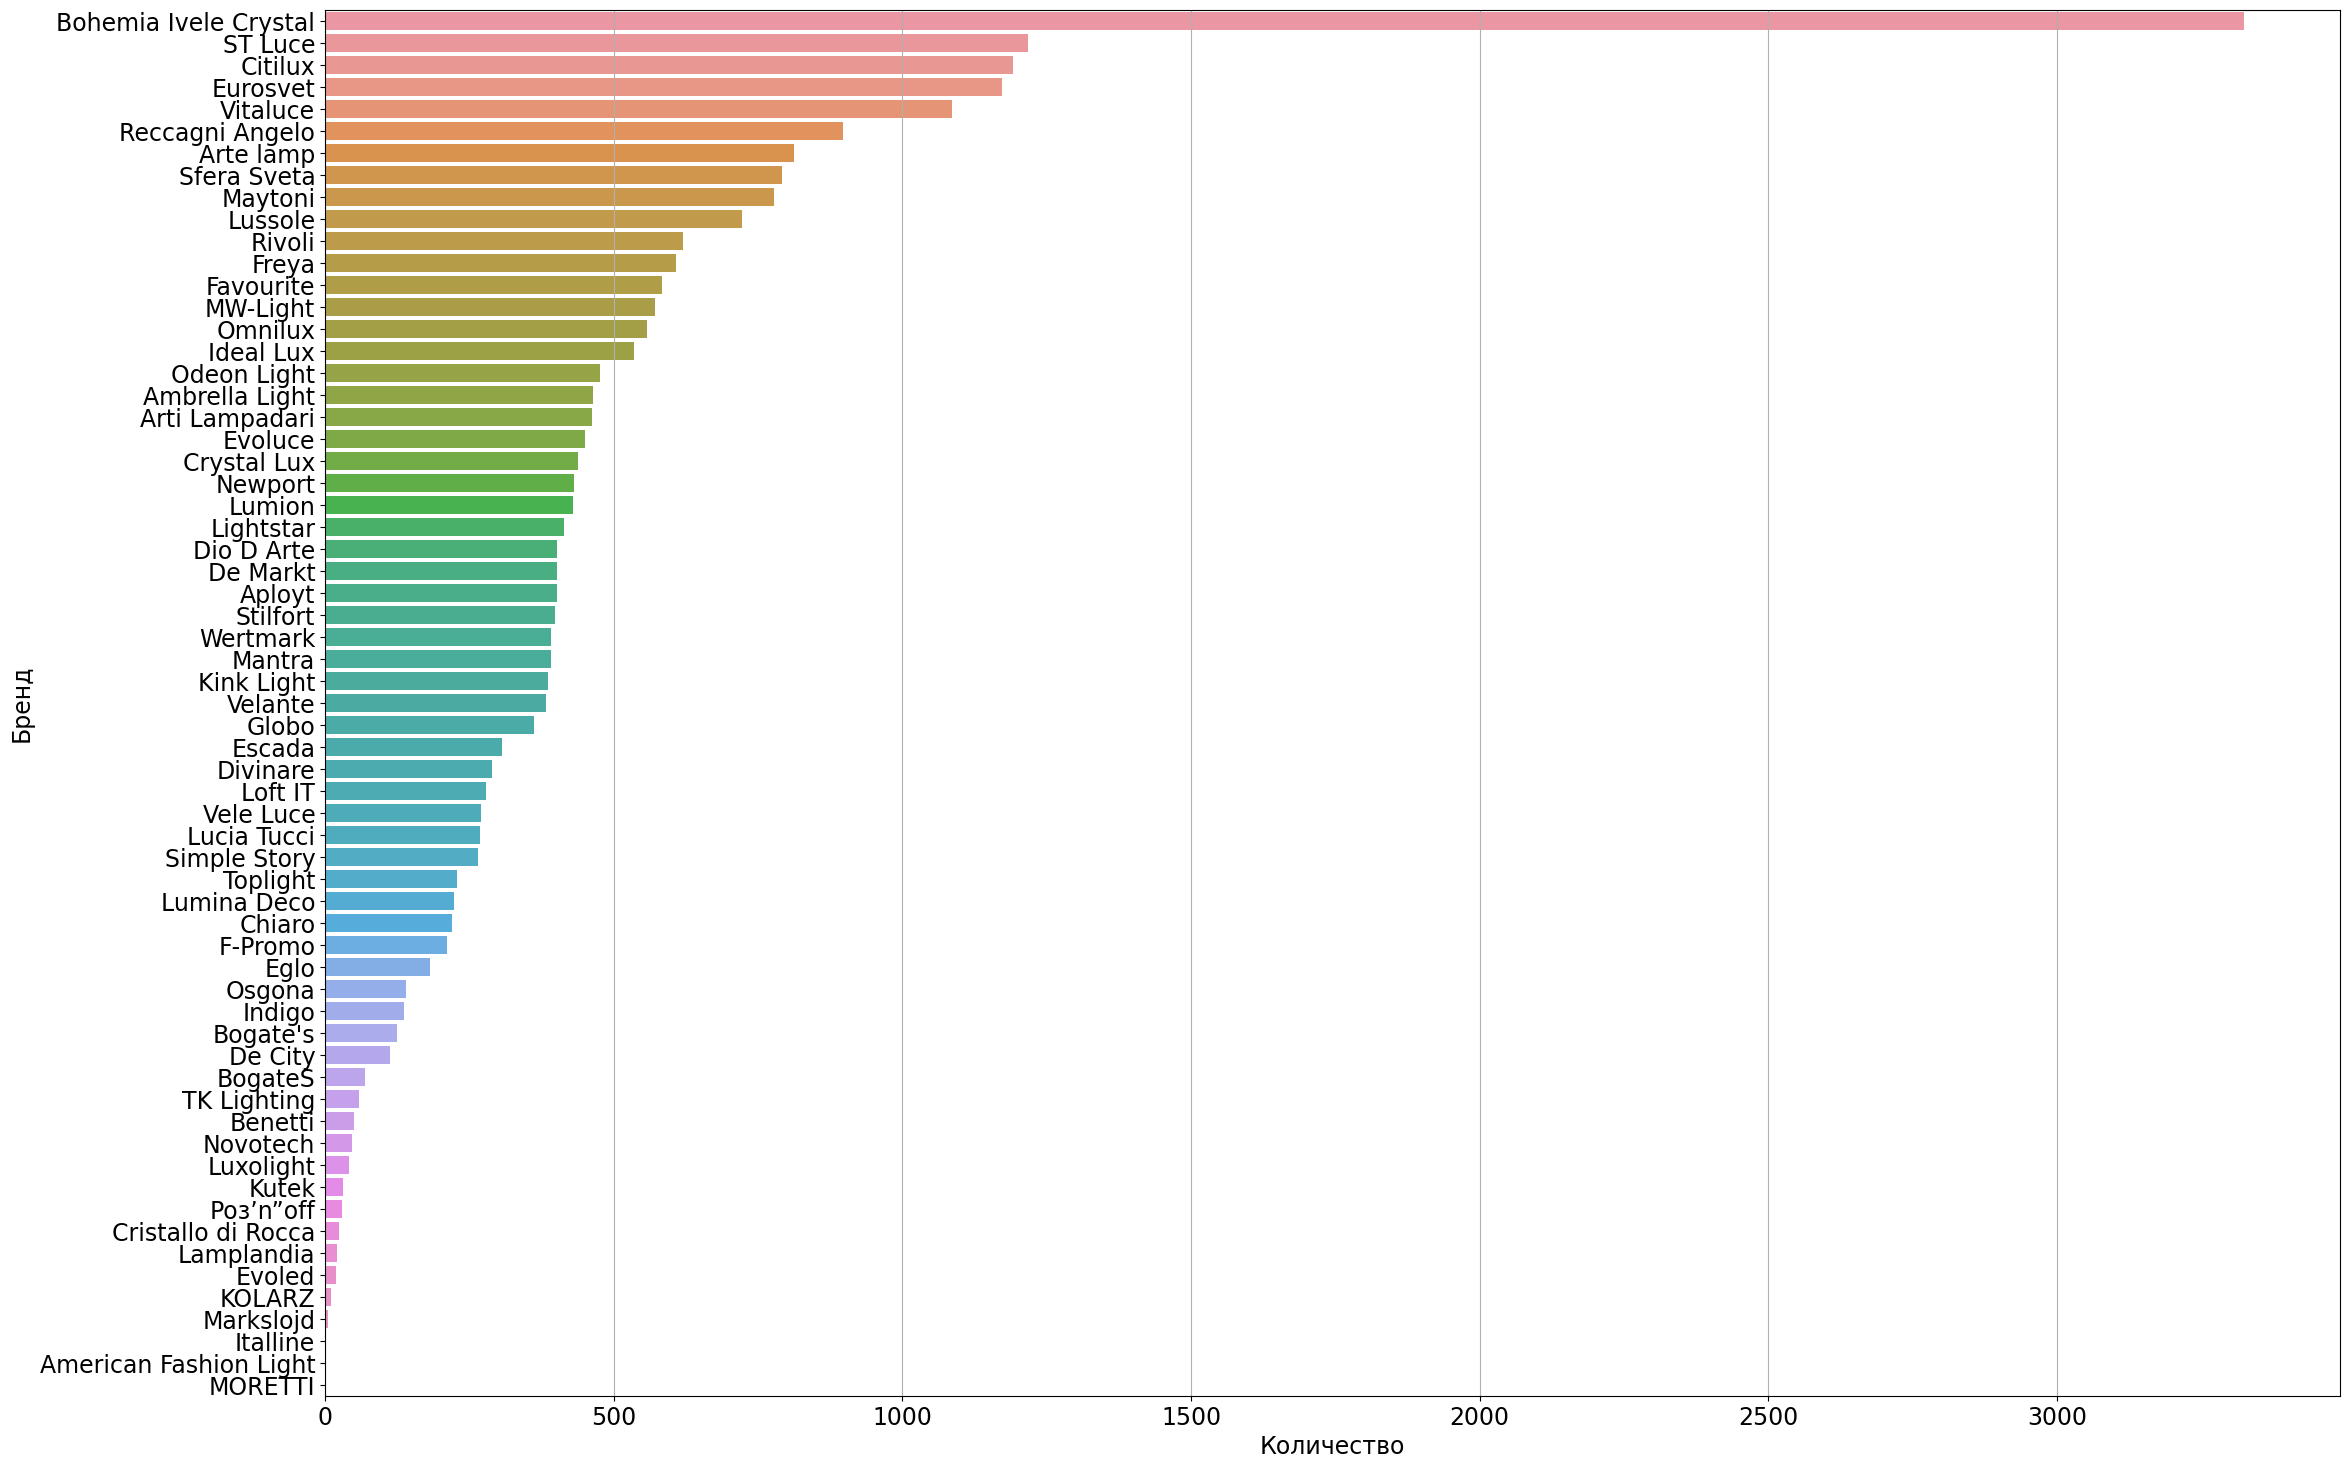

In [14]:
draw_feature_countable("Бренд")

In [15]:
print_feature_counts("Бренд")

Bohemia Ivele Crystal 3324
ST Luce 1218
Citilux 1192
Eurosvet 1173
Vitaluce 1086
Reccagni Angelo 898
Arte lamp 813
Sfera Sveta 792
Maytoni 778
Lussole 723
Rivoli 620
Freya 608
Favourite 584
MW-Light 571
Omnilux 558
Ideal Lux 535
Odeon Light 477
Ambrella Light 464
Arti Lampadari 462
Evoluce 450
Crystal Lux 439
Newport 431
Lumion 429
Lightstar 414
Dio D Arte 402
De Markt 401
Aployt 401
Stilfort 399
Wertmark 392
Mantra 391
Kink Light 386
Velante 382
Globo 362
Escada 306
Divinare 289
Loft IT 279
Vele Luce 270
Lucia Tucci 269
Simple Story 265
Toplight 228
Lumina Deco 223
Chiaro 220
F-Promo 211
Eglo 181
Osgona 140
Indigo 136
Bogate's 125
De City 113
BogateS 70
TK Lighting 58
Benetti 51
Novotech 46
Luxolight 42
Kutek 31
Роз’n”off 30
Cristallo di Rocca 25
Lamplandia 21
Evoled 19
KOLARZ 11
Markslojd 6
Italline 2
American Fashion Light 2
MORETTI 2


In [16]:
remove_all_category_except("Бренд", ["ST Luce", "Citilux", "Eurosvet", "Vitaluce", "Reccagni Angelo", "Arte lamp"])

#### Цвет арматуры

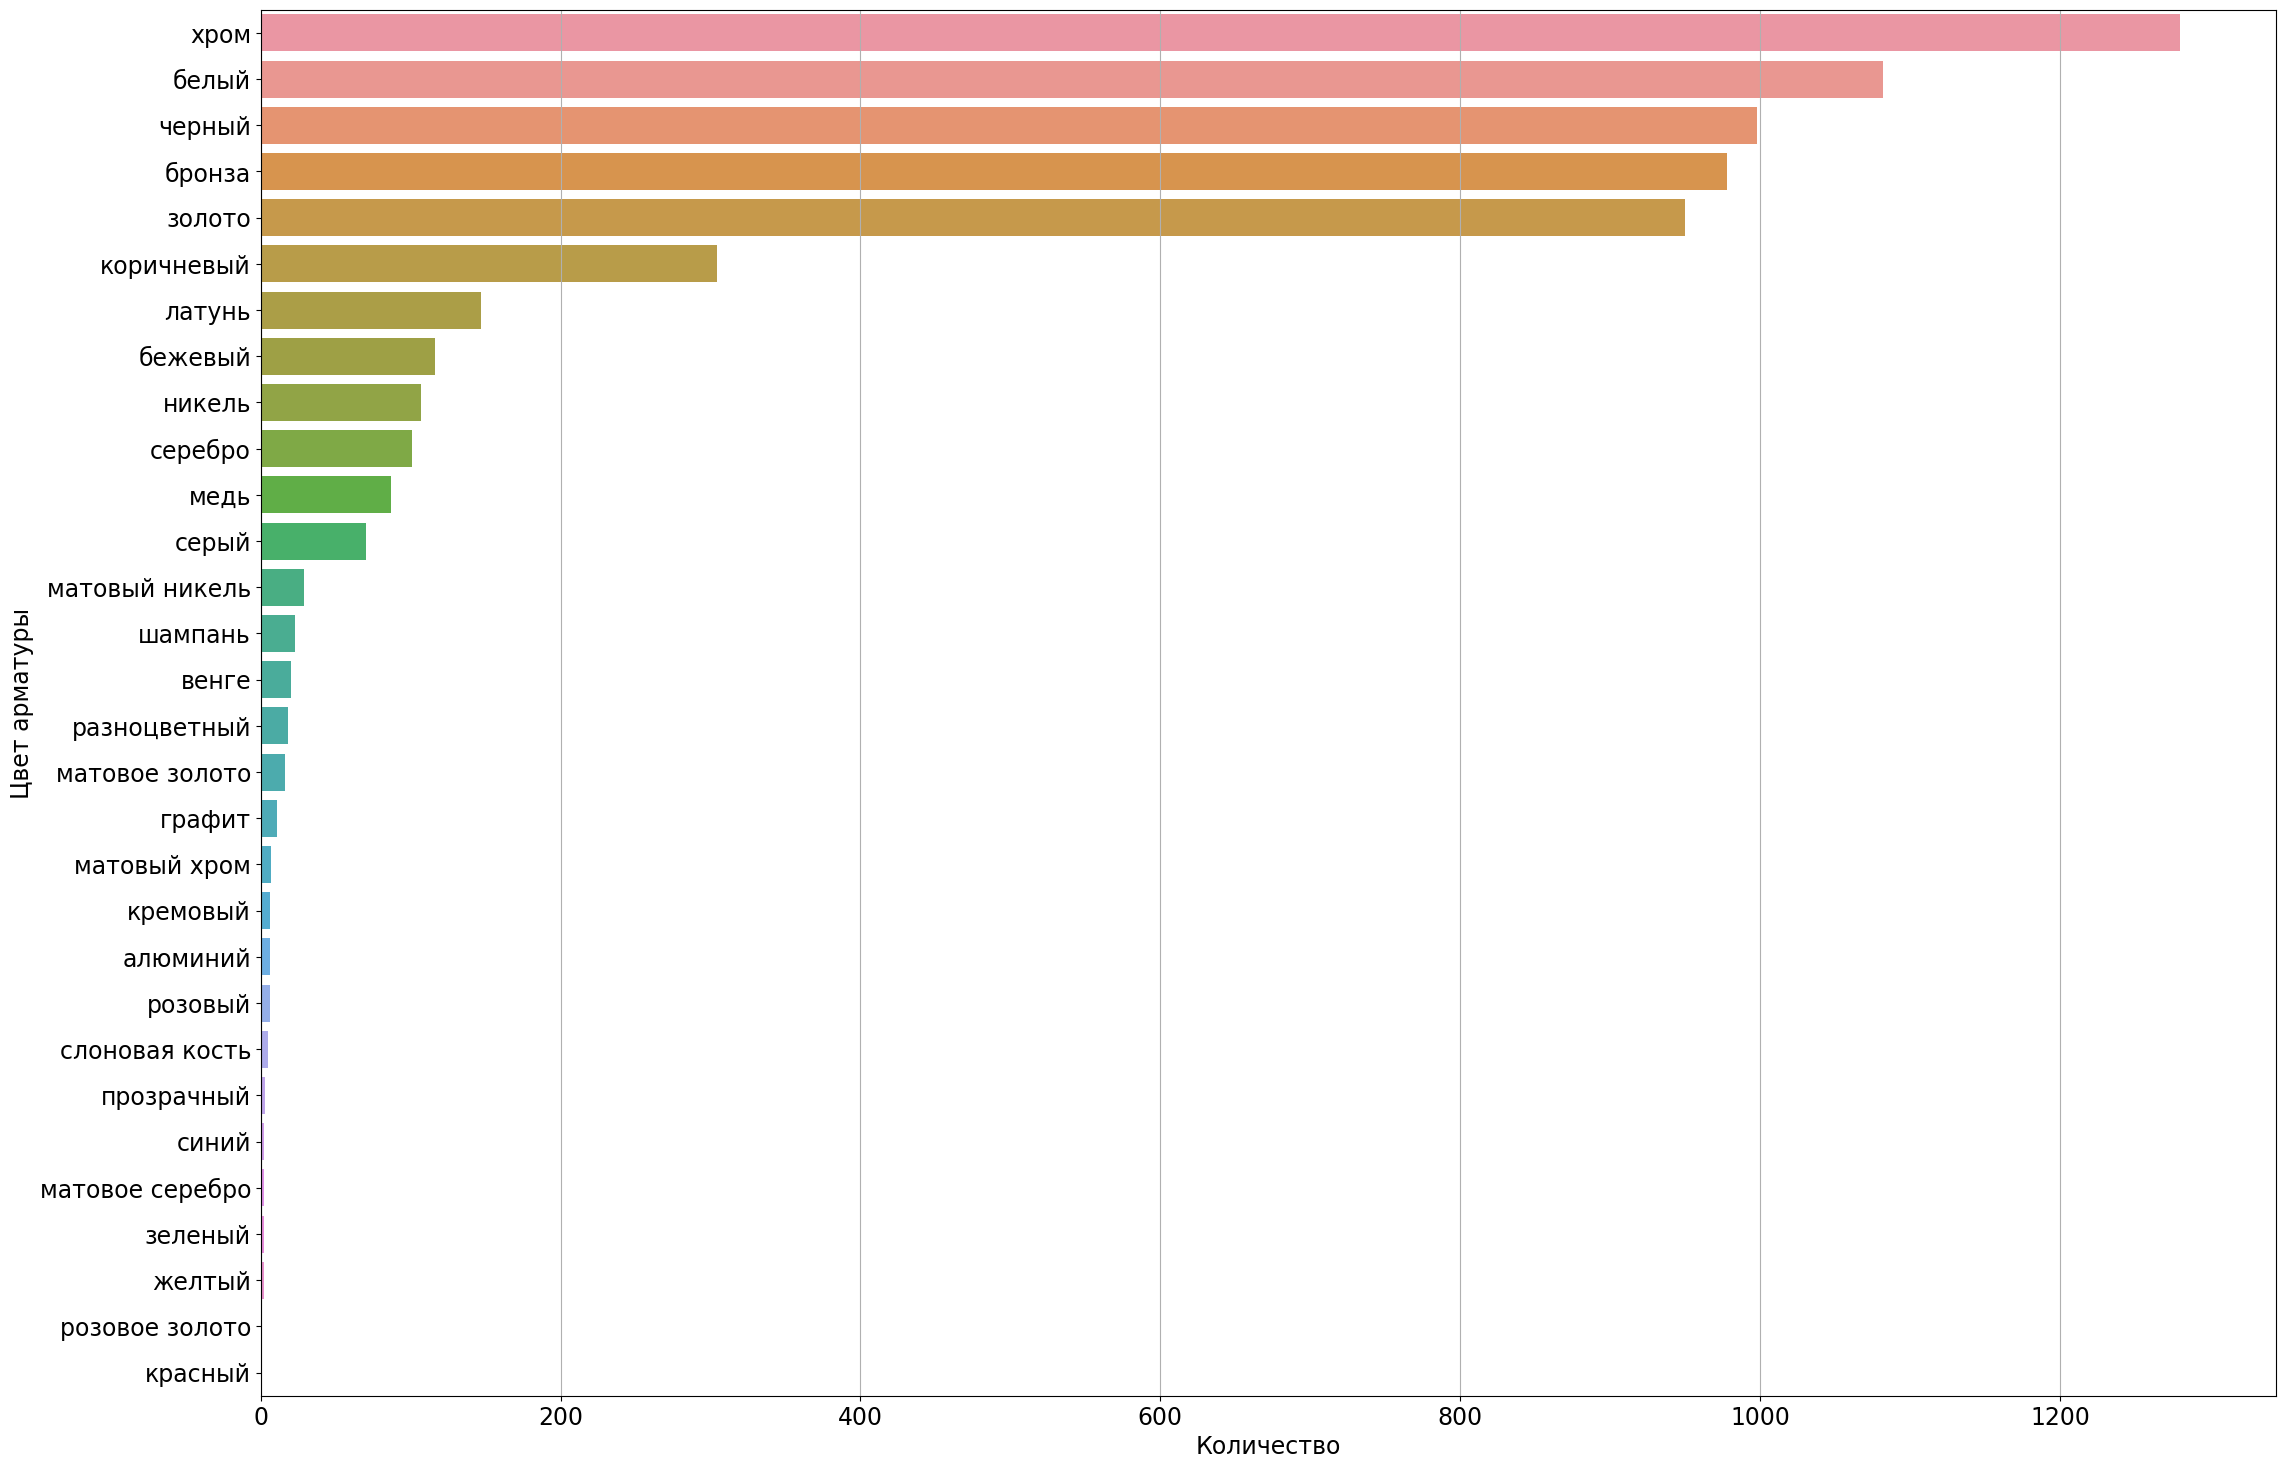

In [17]:
draw_feature_countable("Цвет арматуры")

In [18]:
print_feature_counts("Цвет арматуры")

хром 1280
белый 1082
черный 998
бронза 978
золото 950
коричневый 304
латунь 147
бежевый 116
никель 107
серебро 101
медь 87
серый 70
матовый никель 29
шампань 23
венге 20
разноцветный 18
матовое золото 16
графит 11
матовый хром 7
кремовый 6
алюминий 6
розовый 6
слоновая кость 5
прозрачный 3
синий 2
матовое серебро 2
зеленый 2
желтый 2
розовое золото 1
красный 1


In [19]:
remove_all_category_except("Цвет арматуры", ["хром", "черный", "белый", "золото"])

#### Цвет плафонов

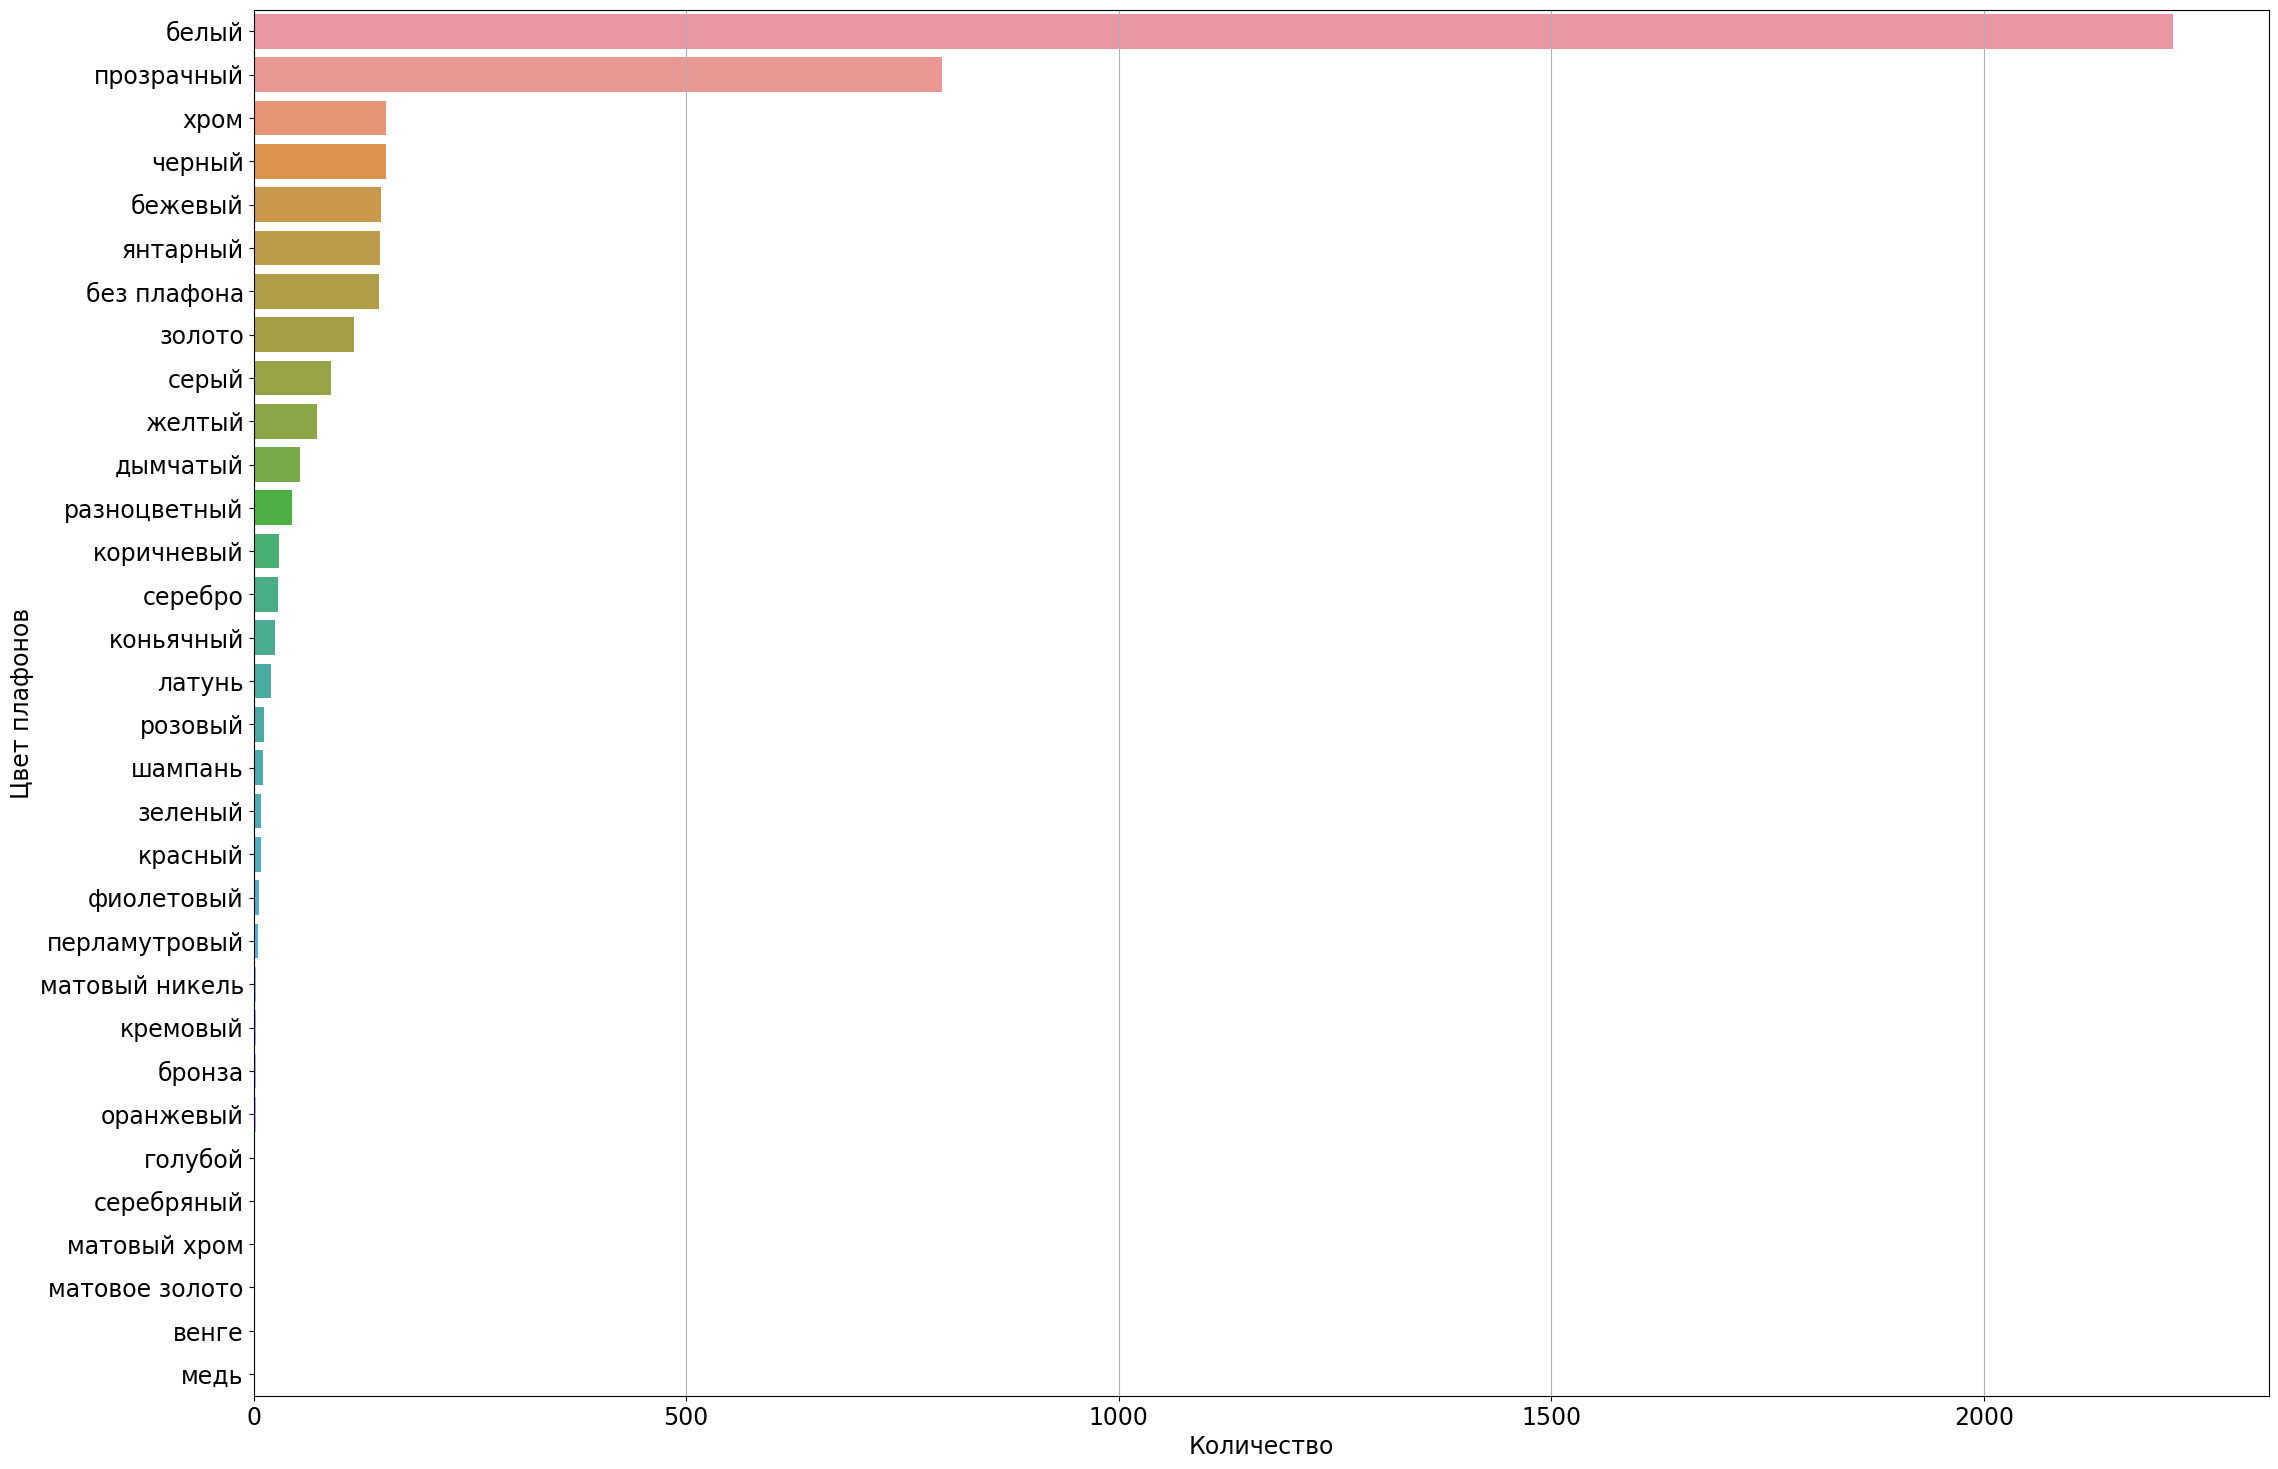

In [20]:
draw_feature_countable("Цвет плафонов")

In [21]:
print_feature_counts("Цвет плафонов")

белый 2218
прозрачный 796
хром 153
черный 153
бежевый 147
янтарный 146
без плафона 145
золото 116
серый 89
желтый 73
дымчатый 54
разноцветный 45
коричневый 29
серебро 28
коньячный 25
латунь 20
розовый 12
шампань 11
зеленый 9
красный 9
фиолетовый 6
перламутровый 5
матовый никель 3
кремовый 3
бронза 3
оранжевый 3
голубой 2
серебряный 2
матовый хром 2
матовое золото 1
венге 1
медь 1


In [22]:
remove_all_category_except("Цвет плафонов", ["черный", "хром", "янтарный", "бежевый", "серый", "золото"])

#### Стиль

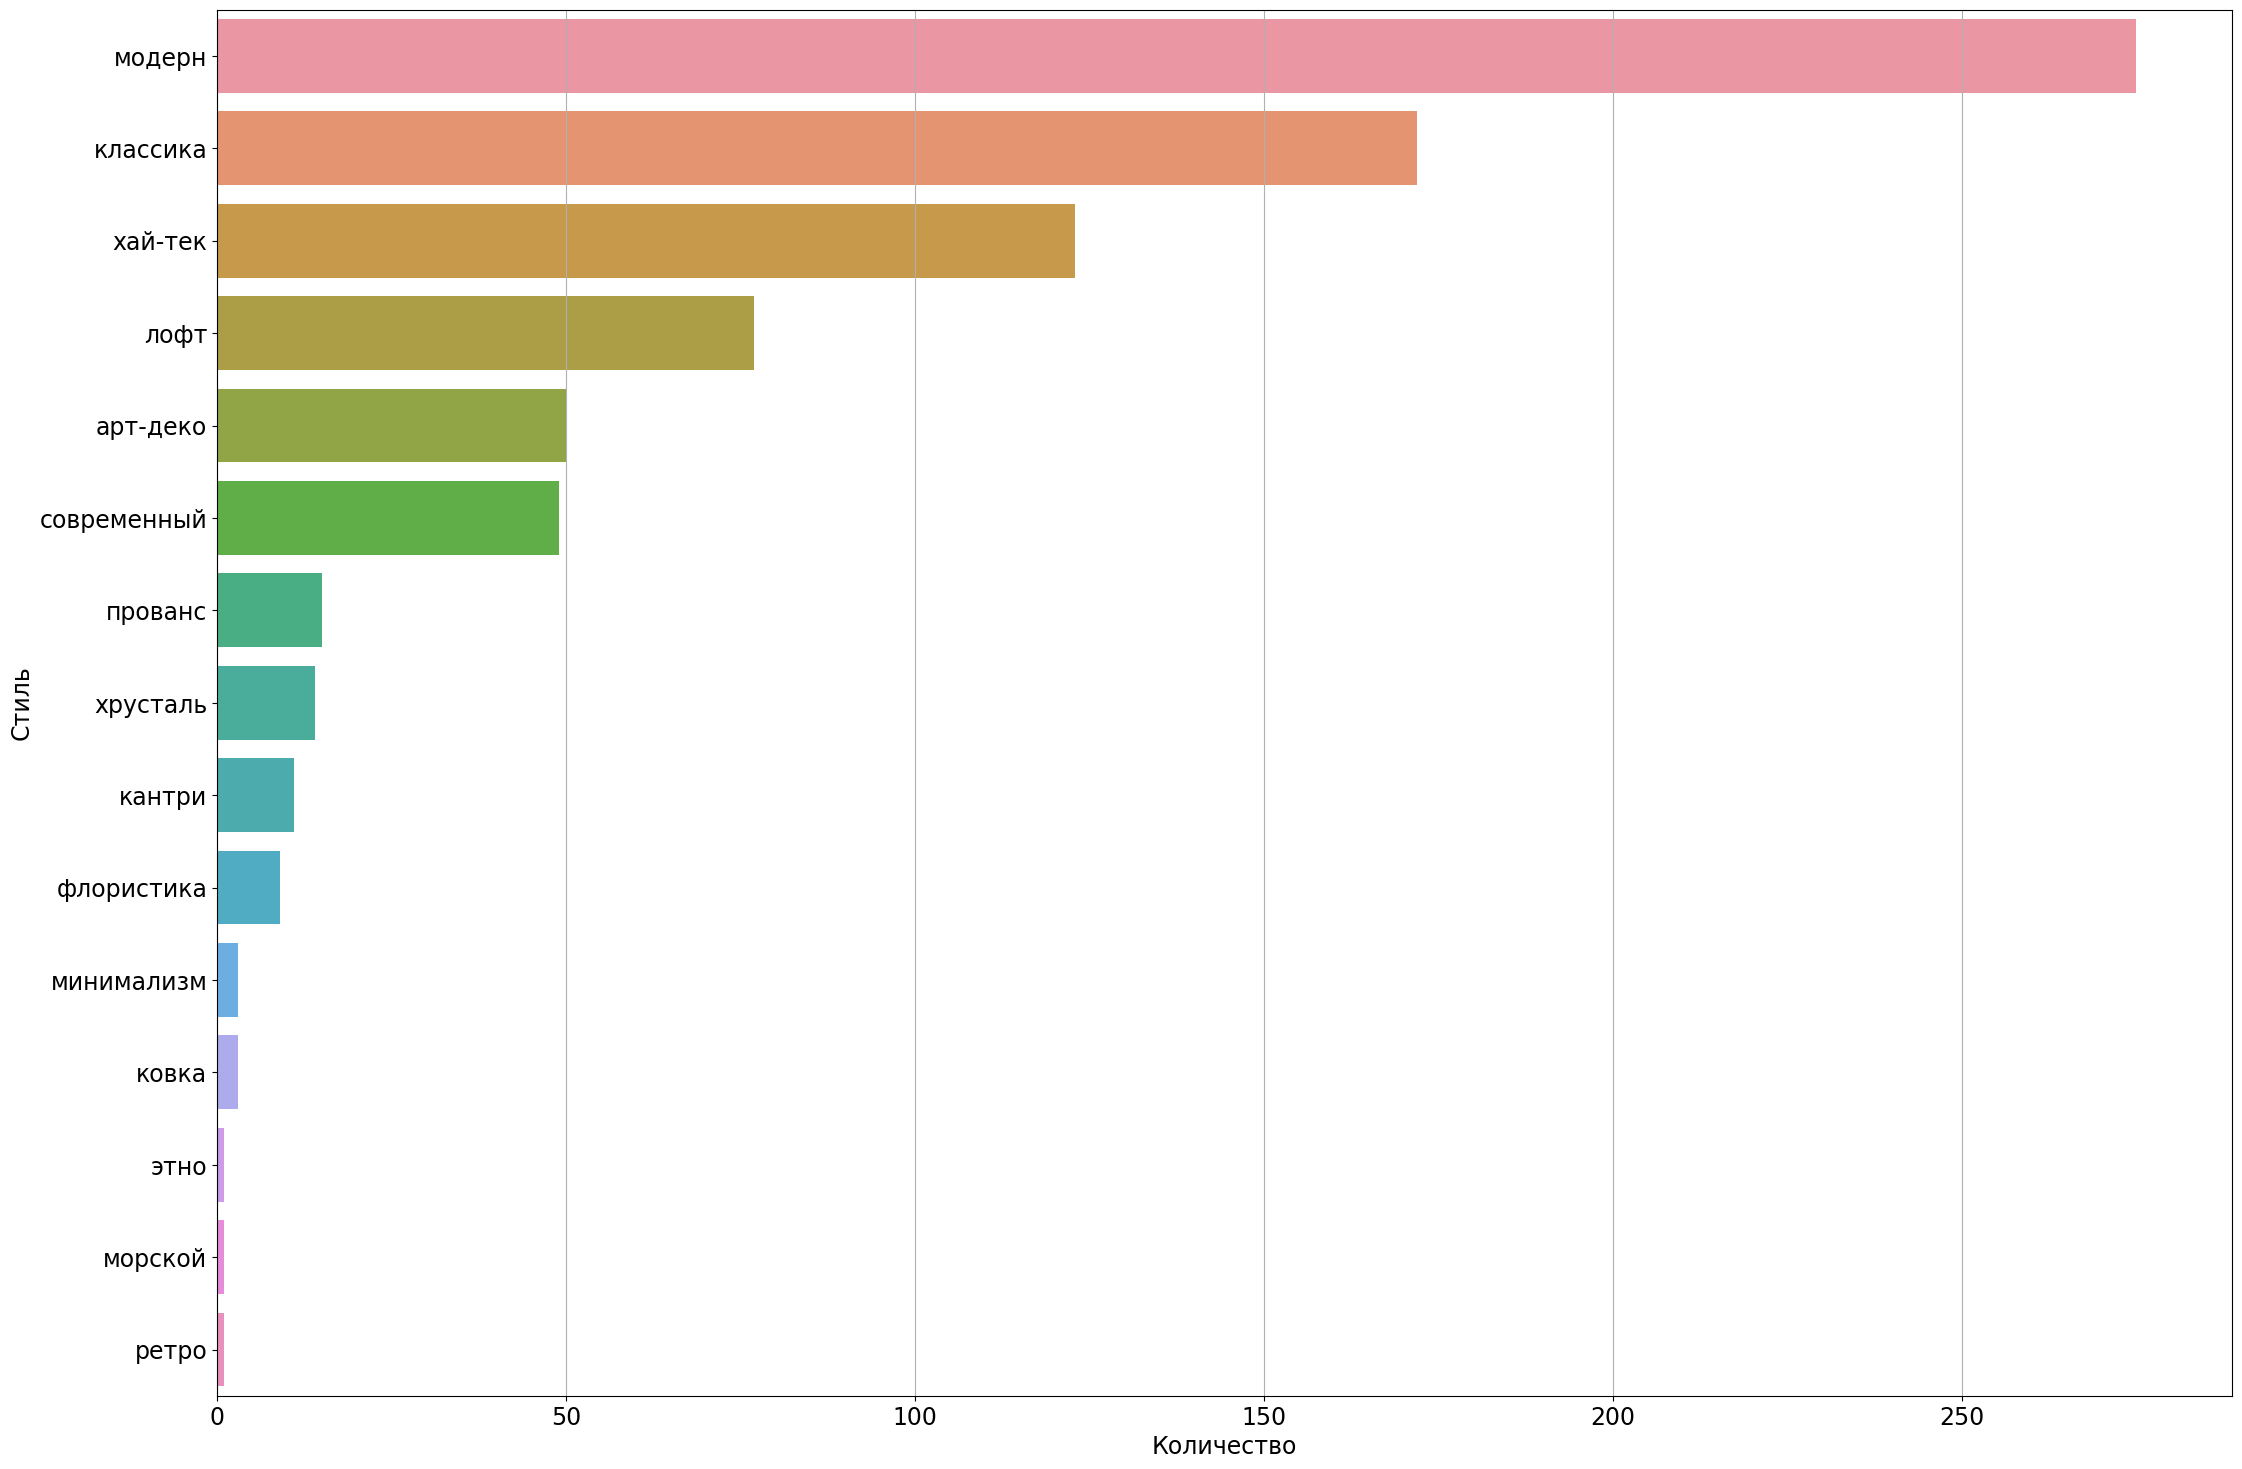

In [23]:
draw_feature_countable("Стиль")

In [24]:
print_feature_counts("Стиль")

модерн 275
классика 172
хай-тек 123
лофт 77
арт-деко 50
современный 49
прованс 15
хрусталь 14
кантри 11
флористика 9
минимализм 3
ковка 3
этно 1
морской 1
ретро 1


In [25]:
remove_all_category_except("Стиль", ["модерн", "хай-тек", "классика", "лофт", "арт-деко", "современный"])

#### Цоколь

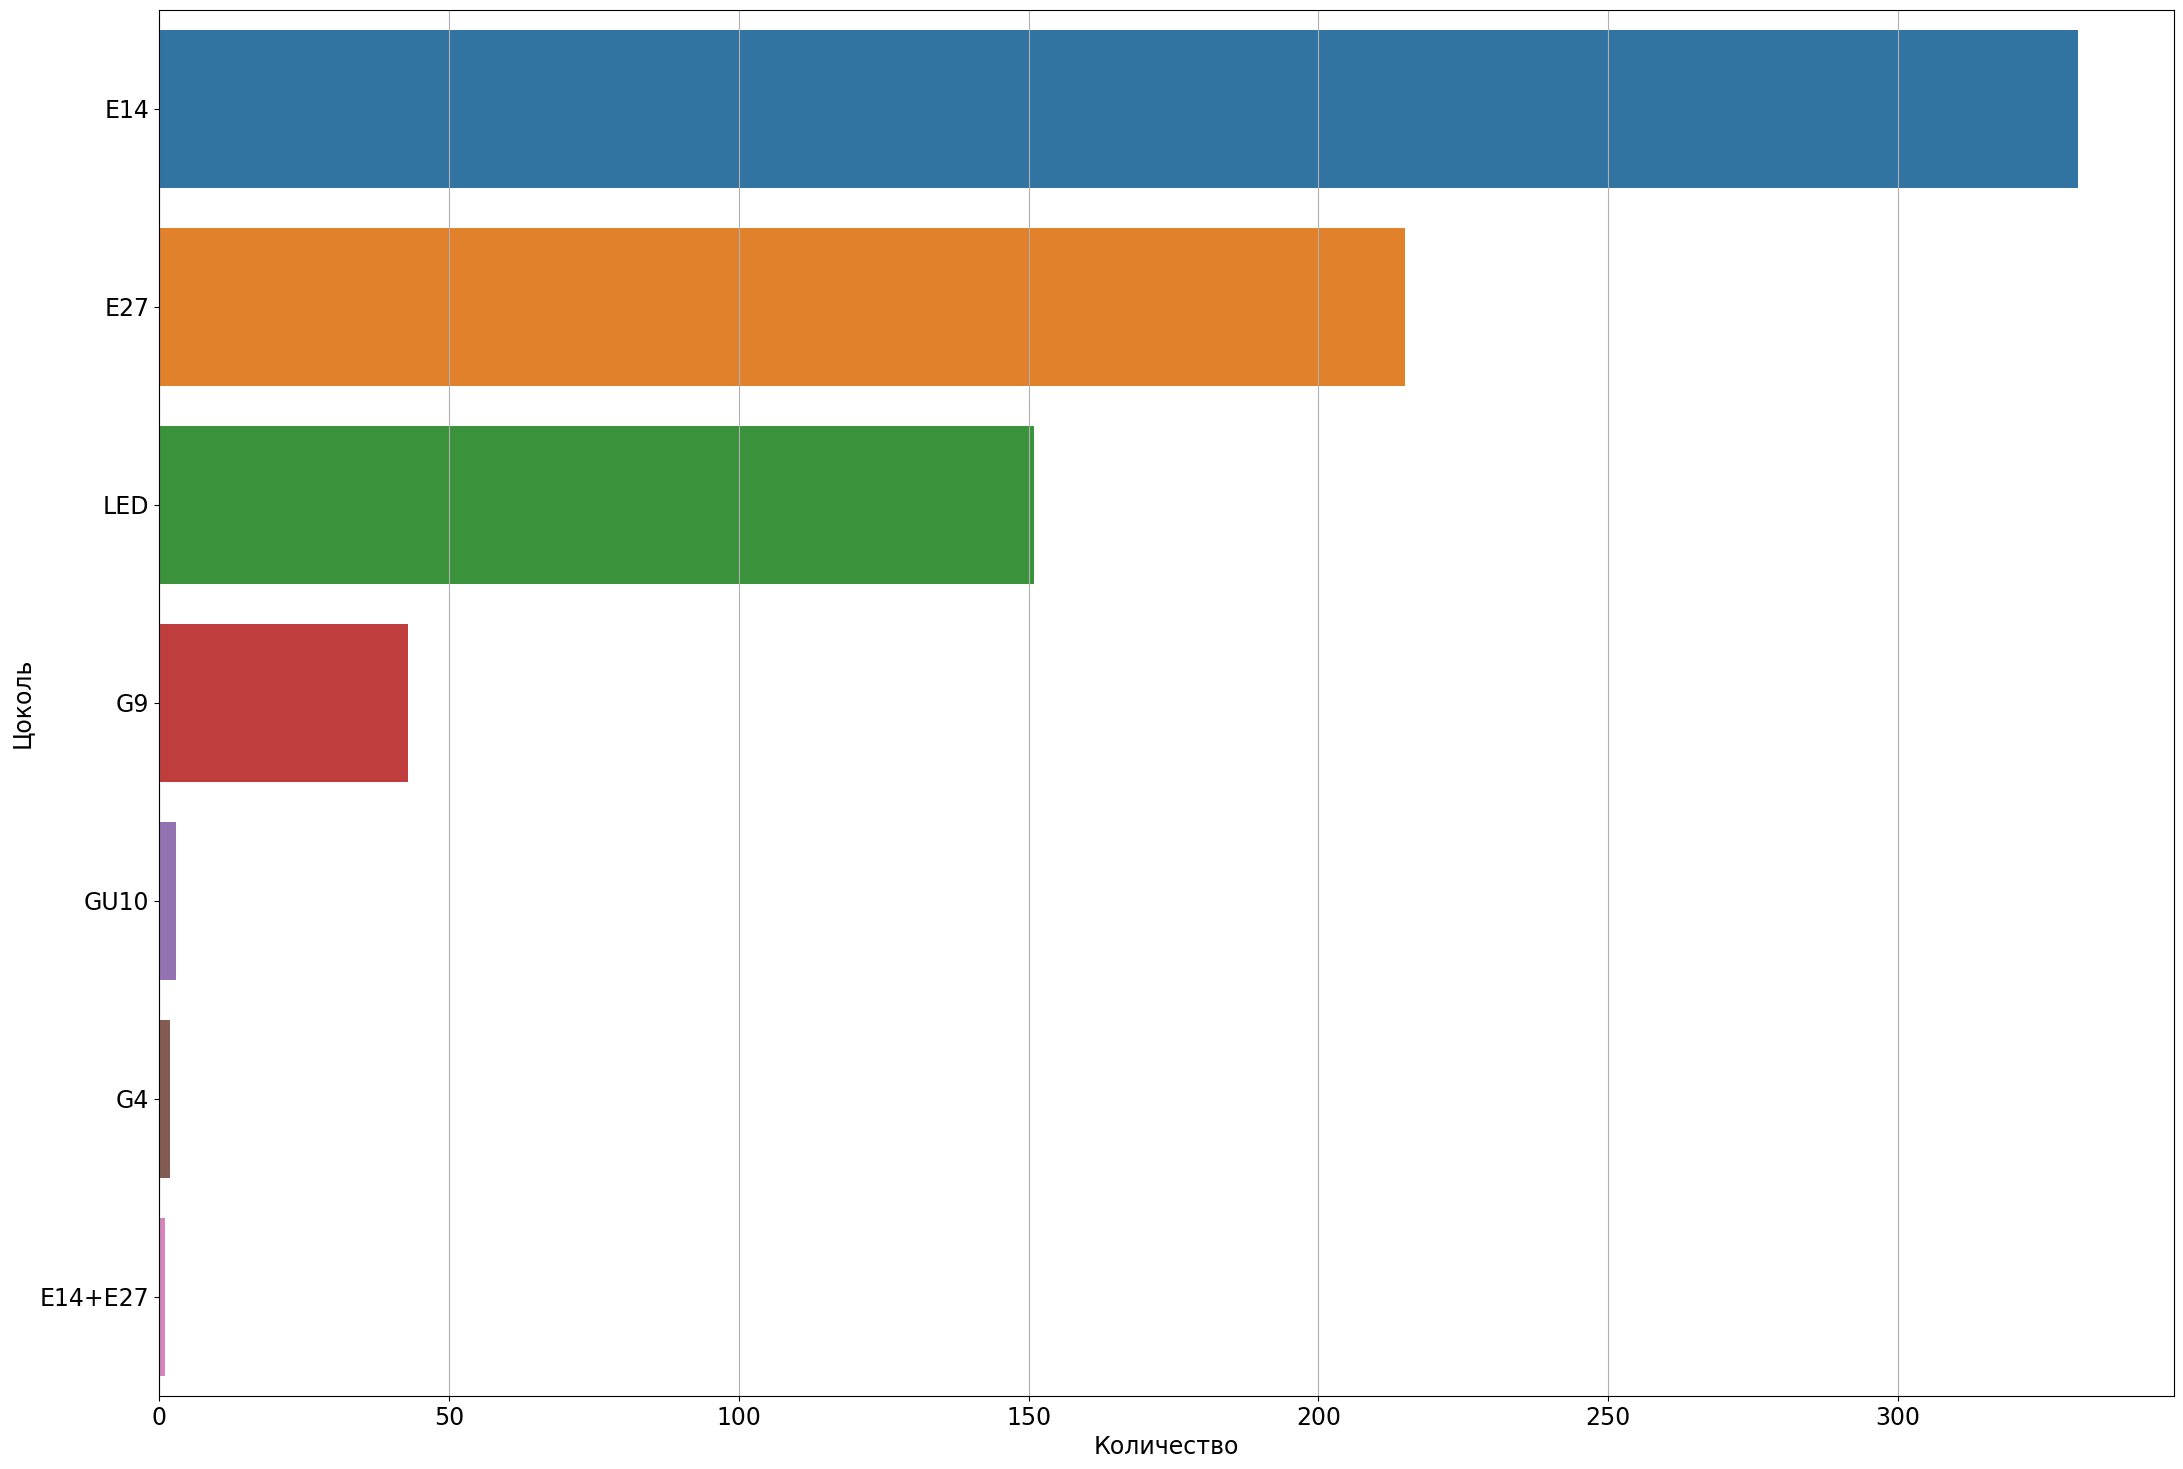

In [26]:
draw_feature_countable("Цоколь")

In [27]:
print_feature_counts("Цоколь")

E14 331
E27 215
LED 151
G9 43
GU10 3
G4 2
E14+E27 1


In [28]:
remove_all_category_except("Цоколь", ["E14", "LED", "E27"])

### Идентификация и фильтрация выбросов по цене

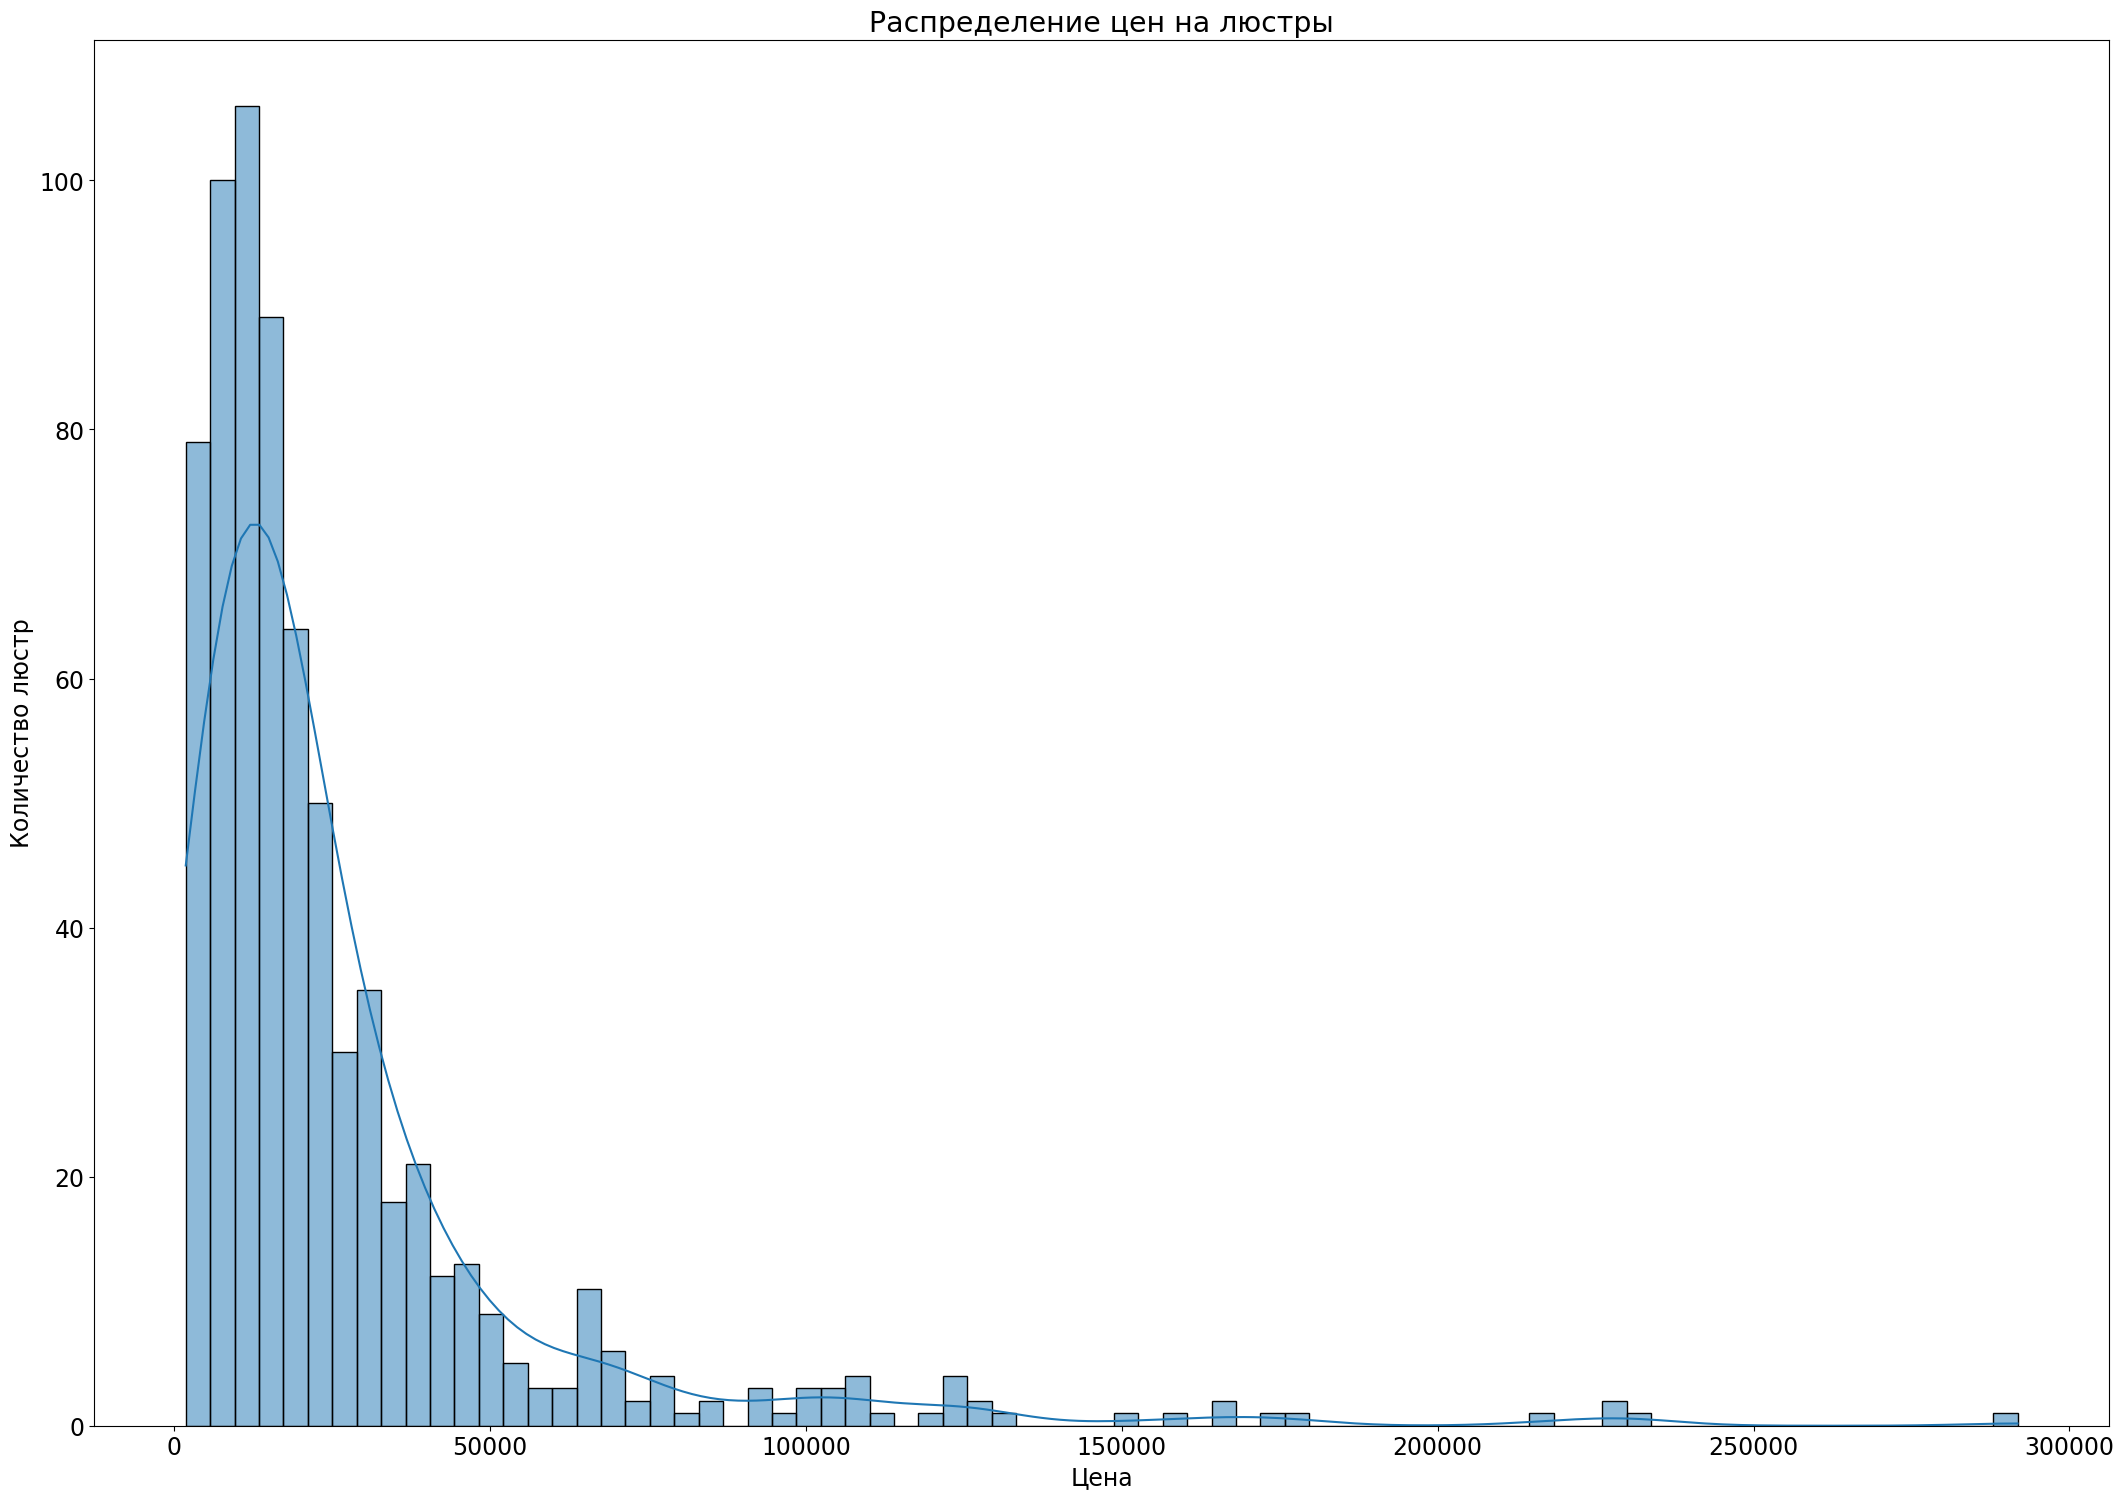

In [29]:
matplotlib.pyplot.figure(figsize=PLT_FIGSIZE)
seaborn.histplot(msveta[FEATURES_RU_EN["Цена"]], bins = 75, kde=True)
matplotlib.pyplot.title('Распределение цен на люстры')
matplotlib.pyplot.xlabel('Цена')
matplotlib.pyplot.ylabel('Количество люстр')
matplotlib.pyplot.show()

In [30]:
q_1 = msveta[FEATURES_RU_EN["Цена"]].quantile(0.25)
q_3 = msveta[FEATURES_RU_EN["Цена"]].quantile(0.75)
iqr = q_3 - q_1
lower_bound = q_1 - 1.5 * iqr
upper_bound = q_3 + 1.5 * iqr

In [31]:
lower_bound

-20700.0

In [32]:
upper_bound

59300.0

In [33]:
msveta = msveta[(msveta[FEATURES_RU_EN["Цена"]] >= lower_bound) & (msveta[FEATURES_RU_EN["Цена"]] <= upper_bound)]

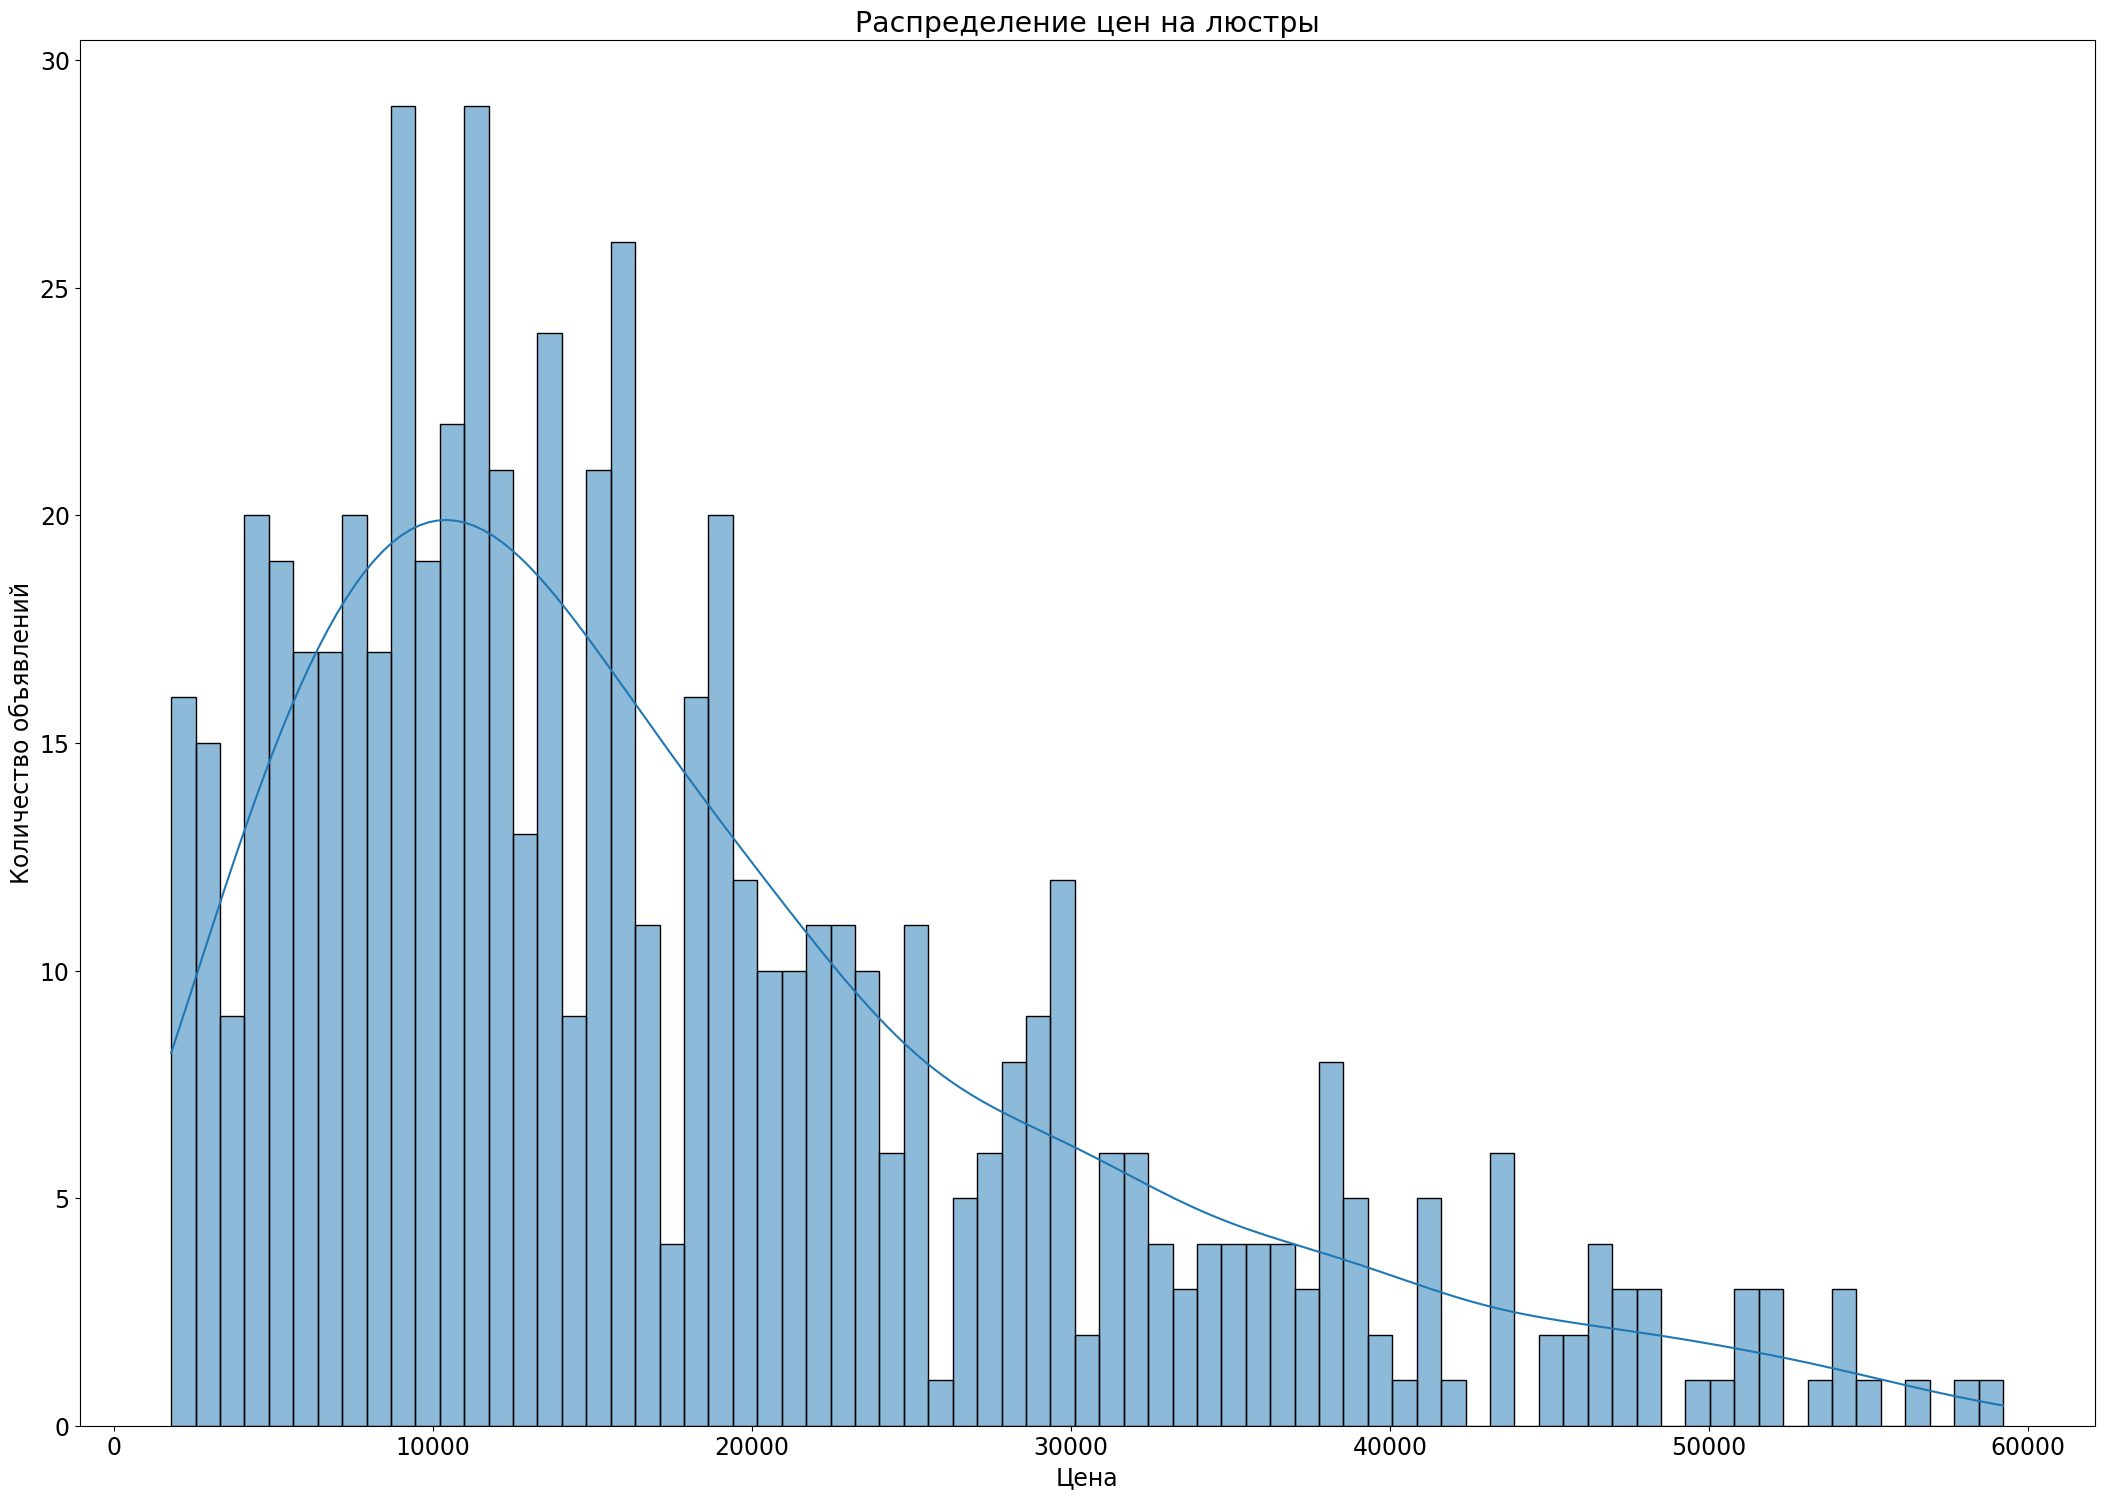

In [34]:
matplotlib.pyplot.figure(figsize=PLT_FIGSIZE)
seaborn.histplot(msveta[FEATURES_RU_EN["Цена"]], bins = 75, kde=True)
matplotlib.pyplot.title('Распределение цен на люстры')
matplotlib.pyplot.xlabel('Цена')
matplotlib.pyplot.ylabel('Количество объявлений')
matplotlib.pyplot.show()

## Отчёт

### Подготовительный этап

#### Преобразования текстовых значений в числовые

In [35]:
def convert_str2num(str):
    avg = str.find("-")
    if avg < 0:
        return float(str)
    else:
        nums = str.split("-")
        return (float(nums[0]) + float(nums[1])) / 2

In [36]:
for feat in FEATURES_EN_NUMERIC:
    msveta[feat] = msveta[feat].apply(lambda x: convert_str2num(x) if isinstance(x, str) else x)

#### Кодирование унитарного кода

In [37]:
msveta = pandas.get_dummies(msveta, columns = FEATURES_EN_TEXT)

#### Преобразование числовых данных в нормализованные

In [38]:
scaler = sklearn.preprocessing.StandardScaler()
msveta_scaled = copy.deepcopy(msveta)
msveta_scaled[FEATURES_EN_NUMERIC] = scaler.fit_transform(msveta[FEATURES_EN_NUMERIC])

#### Разбиение на `train`, `test` и `valid`

In [39]:
msveta_features = msveta.drop(FEATURES_RU_EN[TARGET_PREDICT], axis = 1)
msveta_target = msveta[FEATURES_RU_EN[TARGET_PREDICT]]

In [40]:
msveta_scaled_features = msveta_scaled.drop(FEATURES_RU_EN[TARGET_PREDICT], axis = 1)
msveta_scaled_target = msveta_scaled[FEATURES_RU_EN[TARGET_PREDICT]]

In [41]:
msveta_features_train, msveta_features_temp, msveta_target_train, msveta_target_temp = sklearn.model_selection.train_test_split(msveta_features, msveta_target, test_size = 0.4, random_state = 42)
msveta_features_valid, msveta_features_test, msveta_target_valid, msveta_target_test = sklearn.model_selection.train_test_split(msveta_features_temp, msveta_target_temp, test_size = 0.5, random_state = 42)

In [42]:
msveta_scaled_features_train, msveta_scaled_features_temp, msveta_scaled_target_train, msveta_scaled_target_temp = sklearn.model_selection.train_test_split(msveta_scaled_features, msveta_scaled_target, test_size = 0.4, random_state = 42)
msveta_scaled_features_valid, msveta_scaled_features_test, msveta_scaled_target_valid, msveta_scaled_target_test = sklearn.model_selection.train_test_split(msveta_scaled_features_temp, msveta_scaled_target_temp, test_size = 0.5, random_state = 42)

#### Вспомогательные функции

In [43]:
def draw_errors(errors_train, errors_valid, errors_test, params, name_param):
    title = "Исследование ошибки от гиперпараметра"
    xlabel = "Гиперпараметр" + " " + name_param
    ylabel = "Ошибка MSE"
    matplotlib.pyplot.figure(figsize = PLT_FIGSIZE)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.plot(params, errors_train, color = COLOR_SET_TRAIN, label = "Множество TRAIN")
    matplotlib.pyplot.plot(params, errors_valid, color = COLOR_SET_VALID, label = "Множество VALID")
    matplotlib.pyplot.plot(params, errors_test, color = COLOR_SET_TEST, label = "Множество TEST")
    matplotlib.pyplot.xlabel(xlabel)
    matplotlib.pyplot.ylabel(ylabel)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

In [44]:
def get_errors(model, train_features, train_target, features, target):
    model.fit(train_features, train_target)
    pred = model.predict(features)
    return FUNC_ERROR(target, pred)

In [45]:
def get_errors_normal(model, features, target):
    return get_errors(model, msveta_features_train, msveta_target_train, features, target)

In [46]:
def get_errors_scaled(model, features, target):
    return get_errors(model, msveta_scaled_features_train, msveta_scaled_target_train, features, target)

### Исследование в зависимости от гиперпараметра

#### Ближайший сосед

In [47]:
constructor = sklearn.neighbors.KNeighborsRegressor
h_params = range(1, 25)
name_param = "n_neighbors"

##### Ненормализованные данные

In [48]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_normal(constructor(n_neighbors = h), msveta_features_train, msveta_target_train))
    errors_valid.append(get_errors_normal(constructor(n_neighbors = h), msveta_features_valid, msveta_target_valid))
    errors_test.append(get_errors_normal(constructor(n_neighbors = h), msveta_features_test, msveta_target_test))

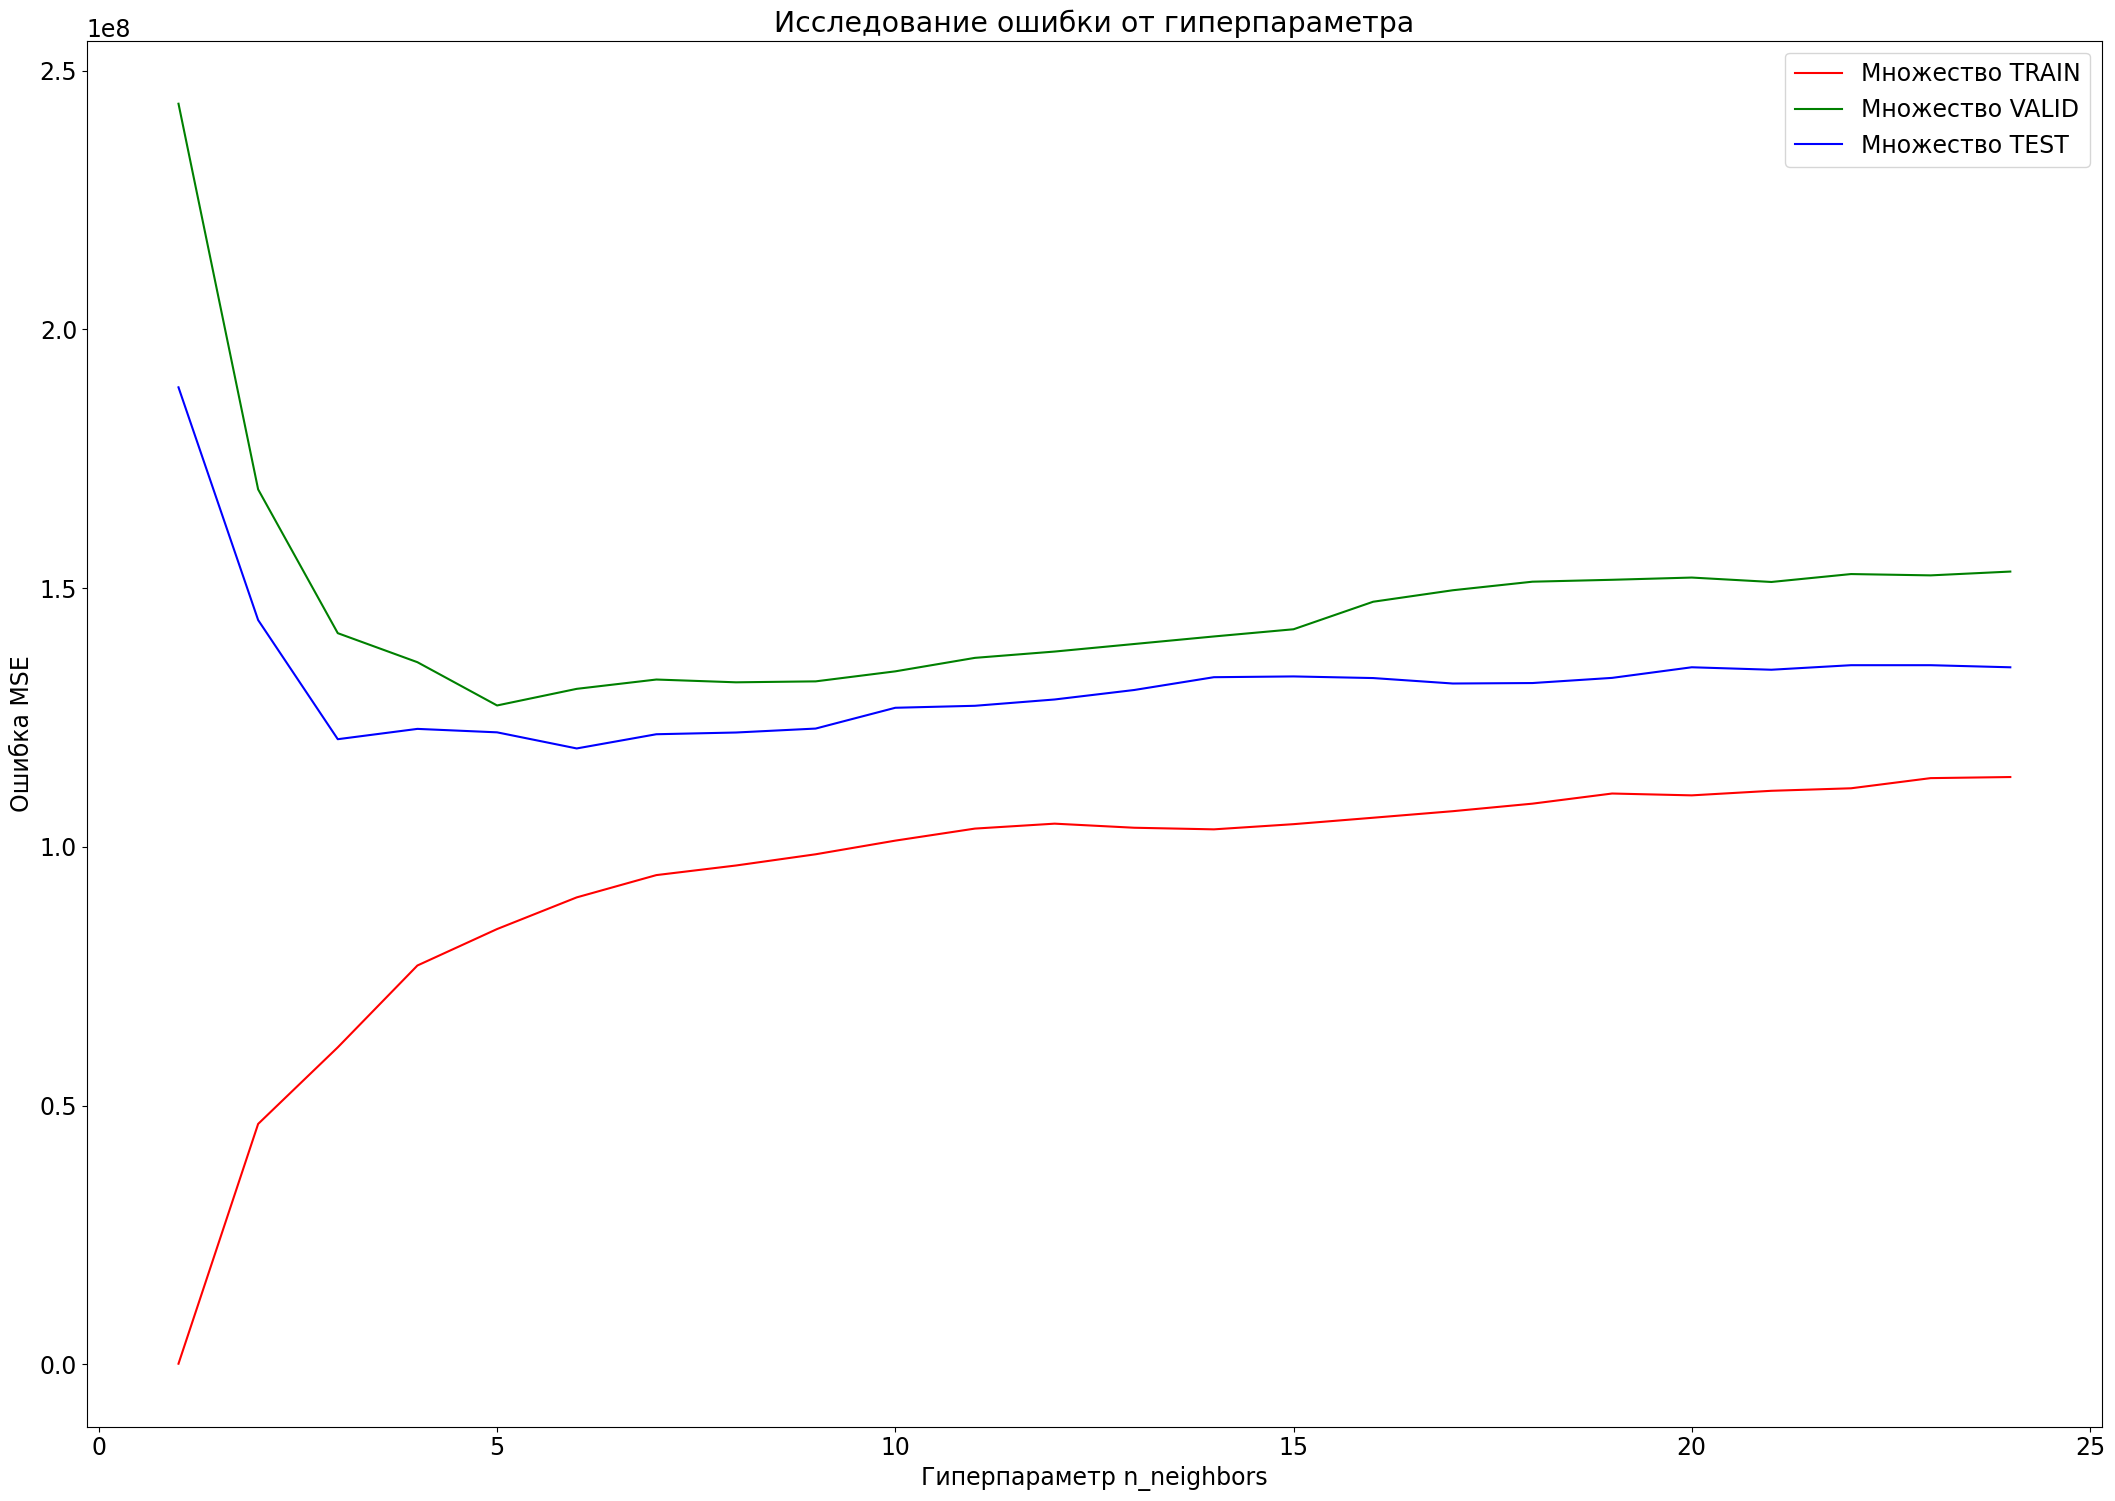

In [49]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

##### Нормализованные данные

In [50]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_scaled(constructor(n_neighbors = h), msveta_scaled_features_train, msveta_scaled_target_train))
    errors_valid.append(get_errors_scaled(constructor(n_neighbors = h), msveta_scaled_features_valid, msveta_scaled_target_valid))
    errors_test.append(get_errors_scaled(constructor(n_neighbors = h), msveta_scaled_features_test, msveta_scaled_target_test))

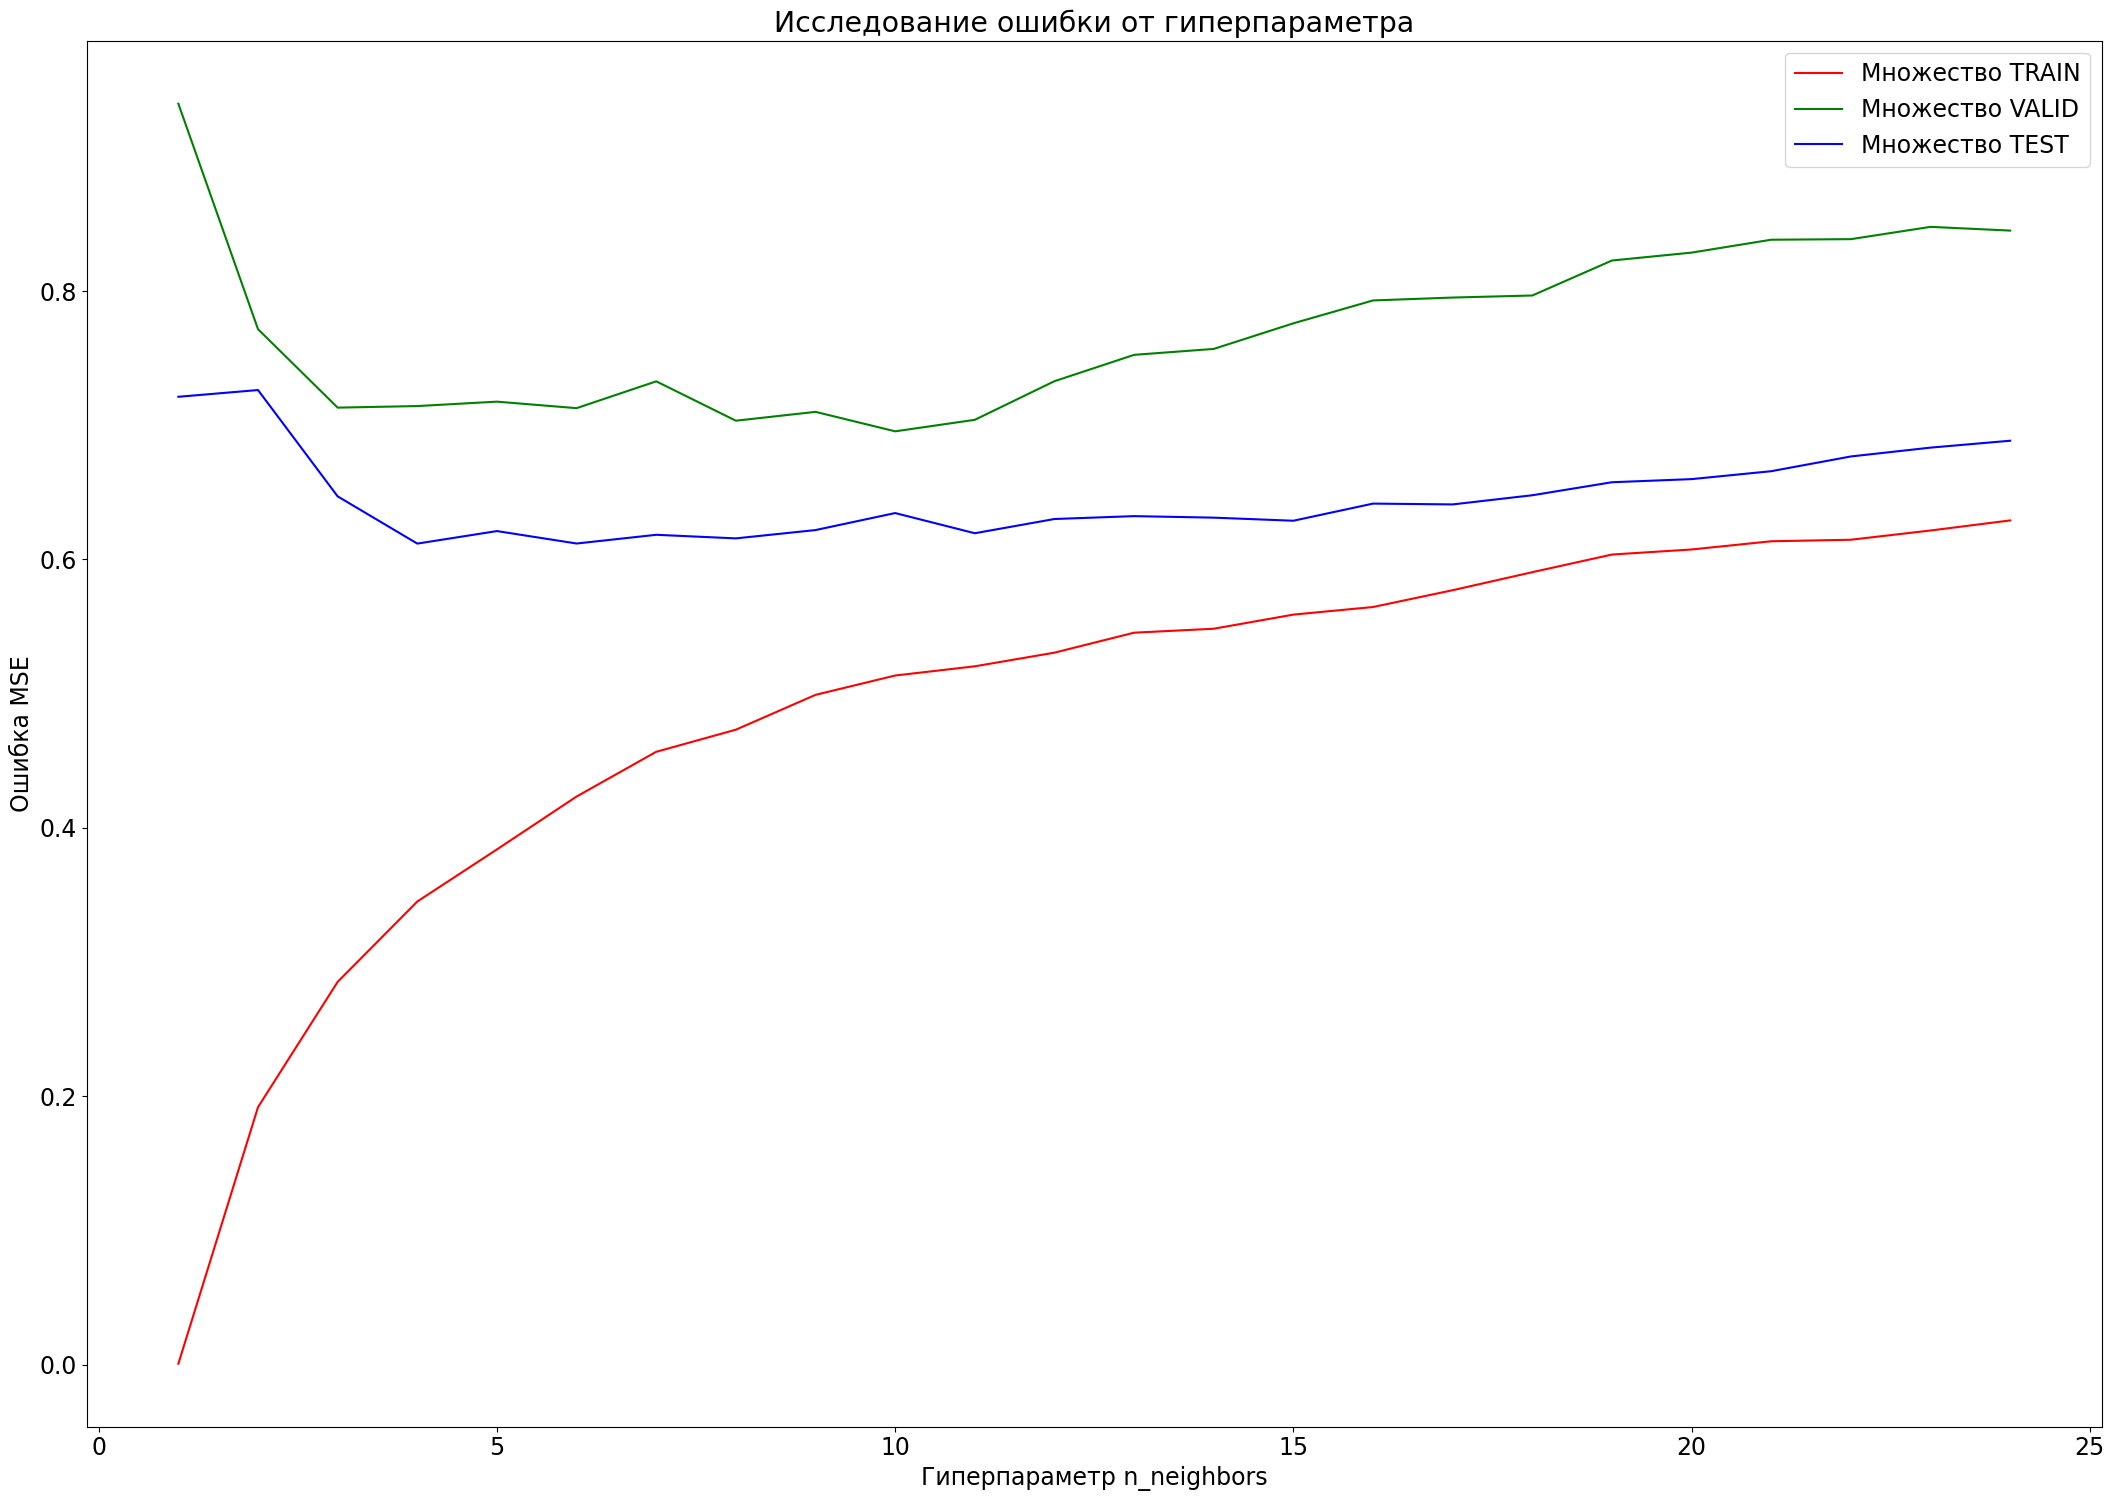

In [51]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

#### Линейная модель

In [52]:
constructor = sklearn.linear_model.SGDRegressor
h_params = numpy.arange(0.001, 0.75, 0.0005)
name_param = "alpha"

##### Ненормализованные данные

In [53]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_normal(constructor(alpha = h), msveta_features_train, msveta_target_train))
    errors_valid.append(get_errors_normal(constructor(alpha = h), msveta_features_valid, msveta_target_valid))
    errors_test.append(get_errors_normal(constructor(alpha = h), msveta_features_test, msveta_target_test))

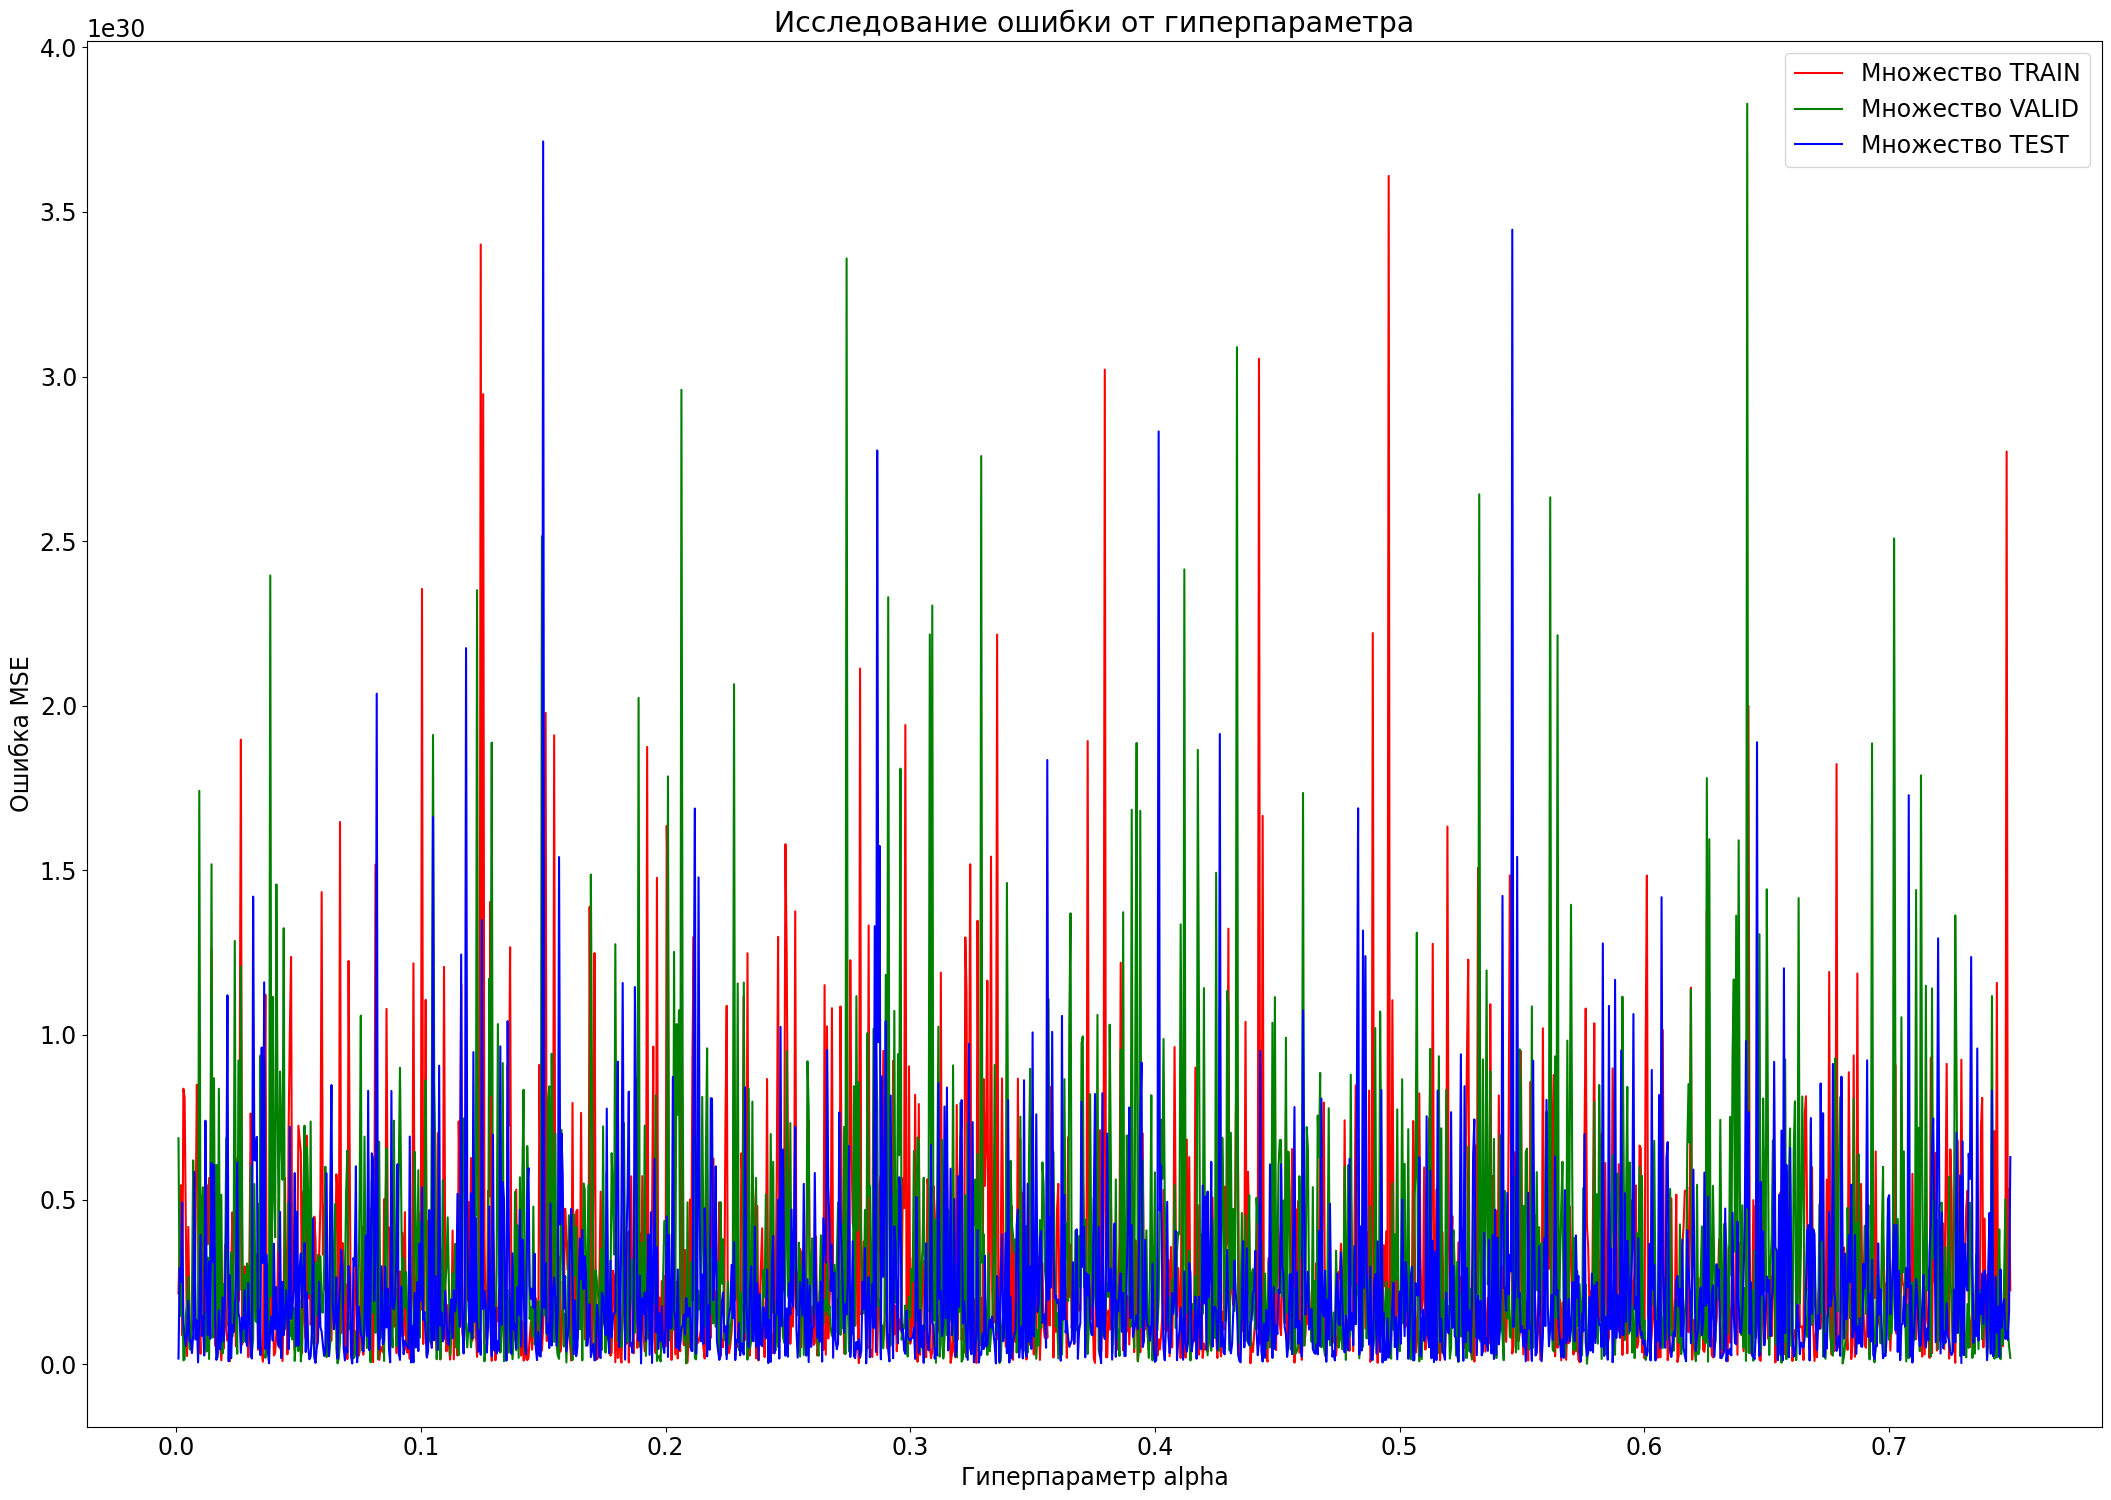

In [54]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

##### Нормализованные данные

In [55]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_scaled(constructor(alpha = h), msveta_scaled_features_train, msveta_scaled_target_train))
    errors_valid.append(get_errors_scaled(constructor(alpha = h), msveta_scaled_features_valid, msveta_scaled_target_valid))
    errors_test.append(get_errors_scaled(constructor(alpha = h), msveta_scaled_features_test, msveta_scaled_target_test))

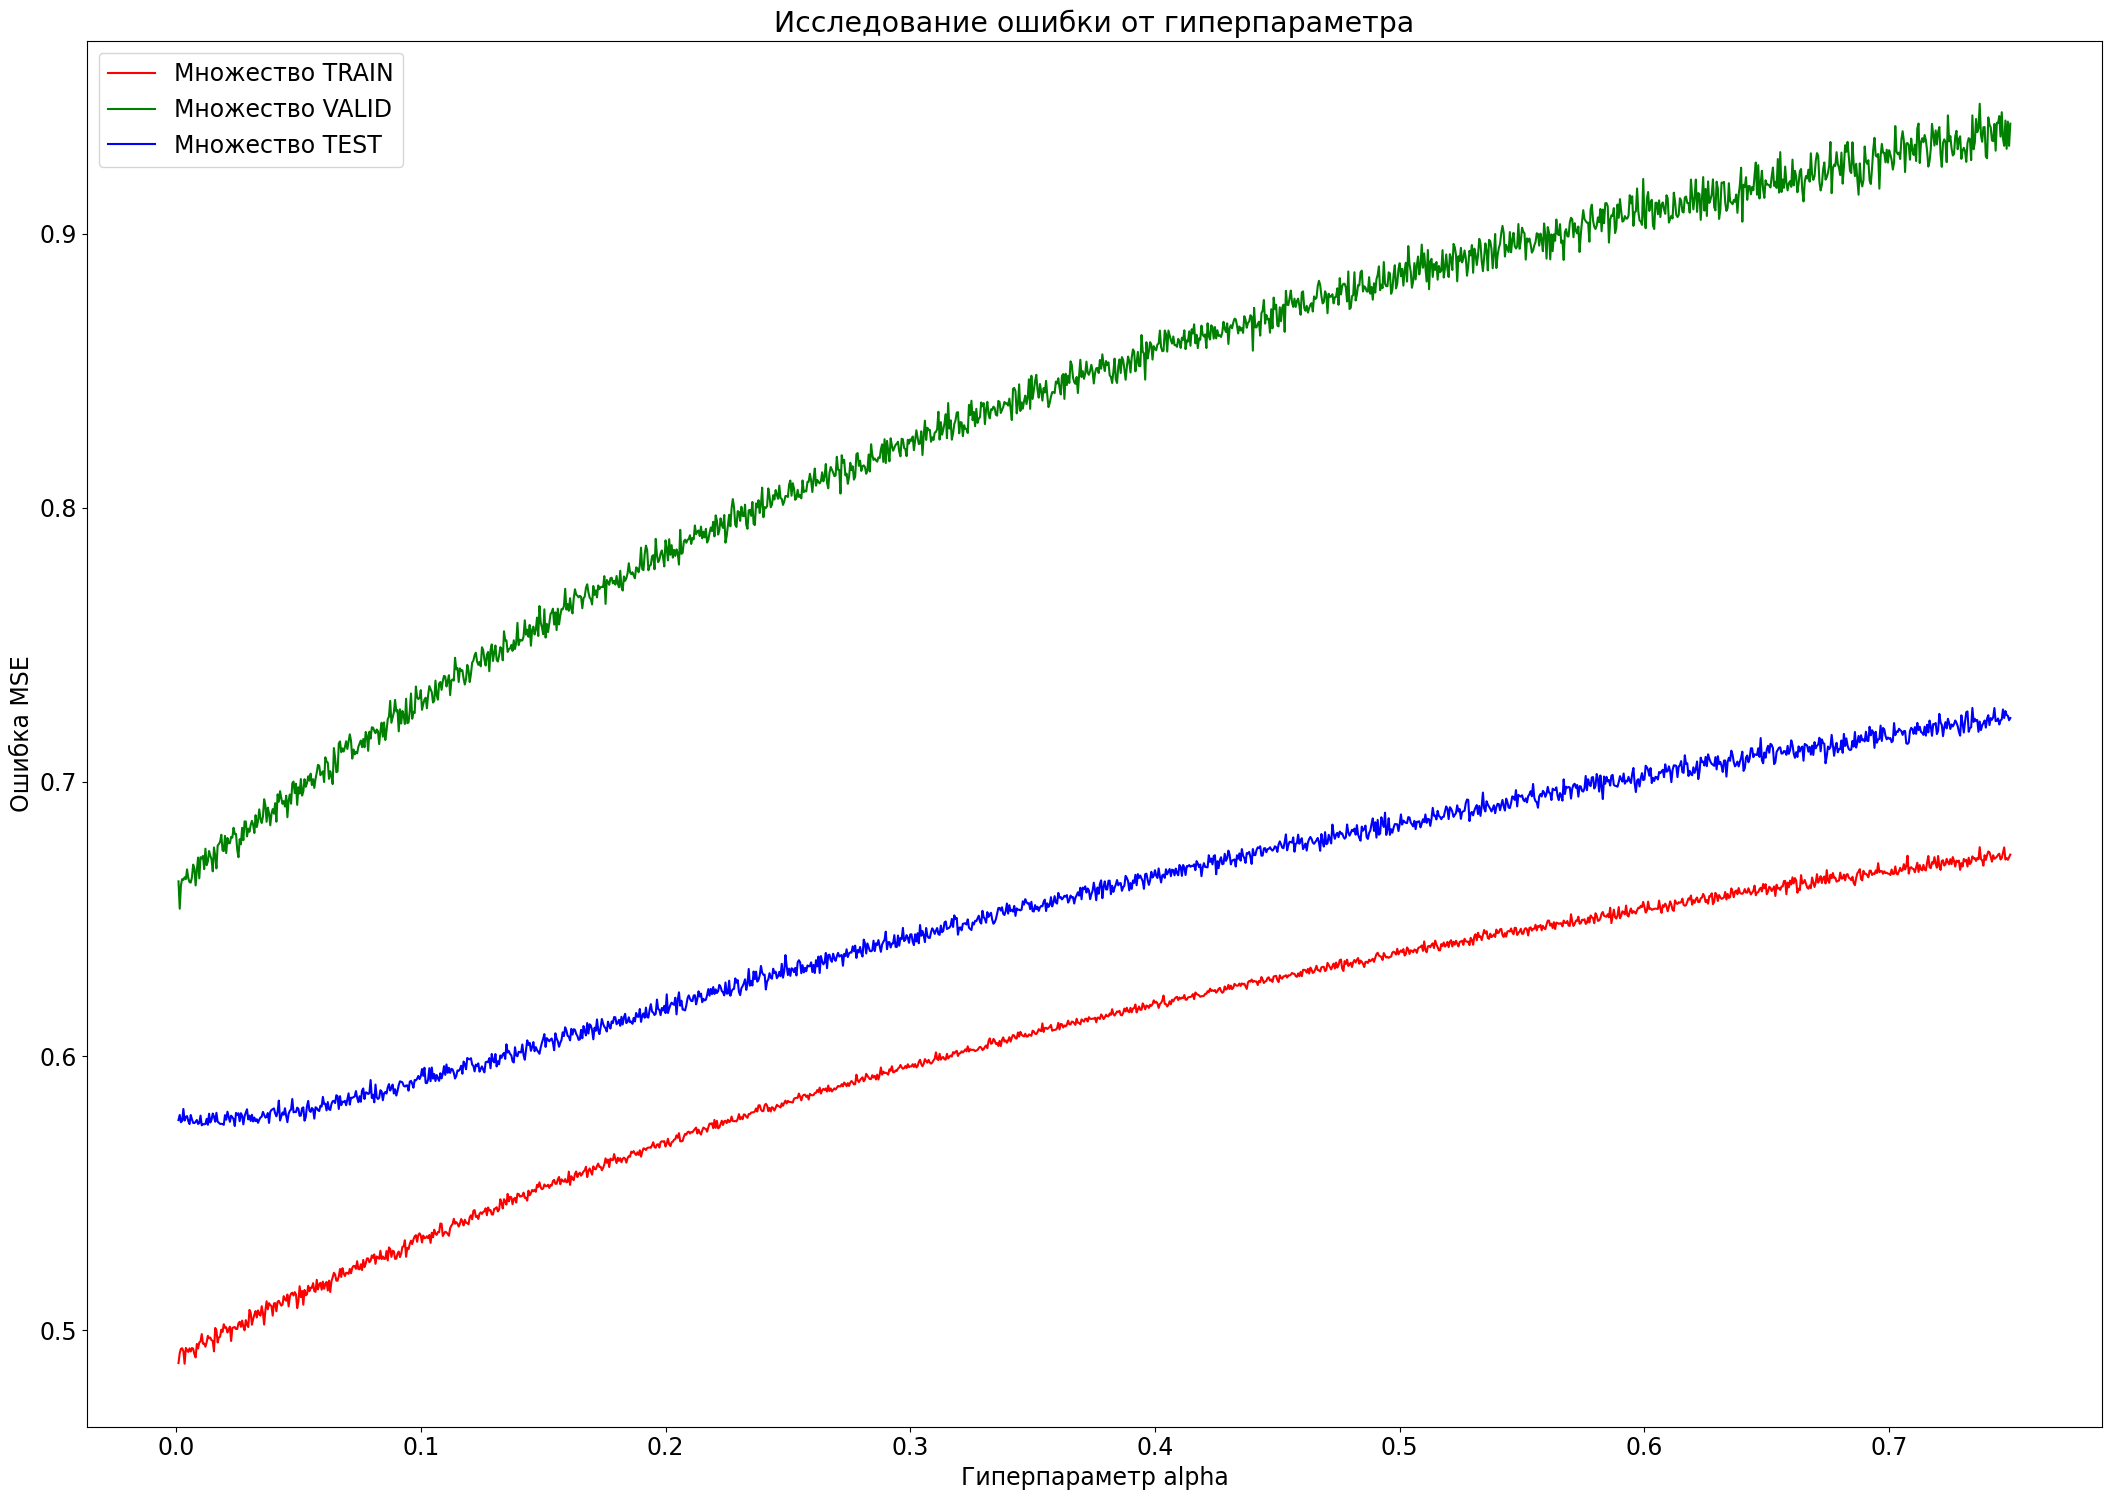

In [56]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

#### Деревья принятия решений

In [57]:
constructor = sklearn.tree.DecisionTreeRegressor
h_params = numpy.arange(1, 12) ** 2
name_param = "max_depth"

##### Ненормализованные данные

In [58]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_normal(constructor(max_depth = h), msveta_features_train, msveta_target_train))
    errors_valid.append(get_errors_normal(constructor(max_depth = h), msveta_features_valid, msveta_target_valid))
    errors_test.append(get_errors_normal(constructor(max_depth = h), msveta_features_test, msveta_target_test))

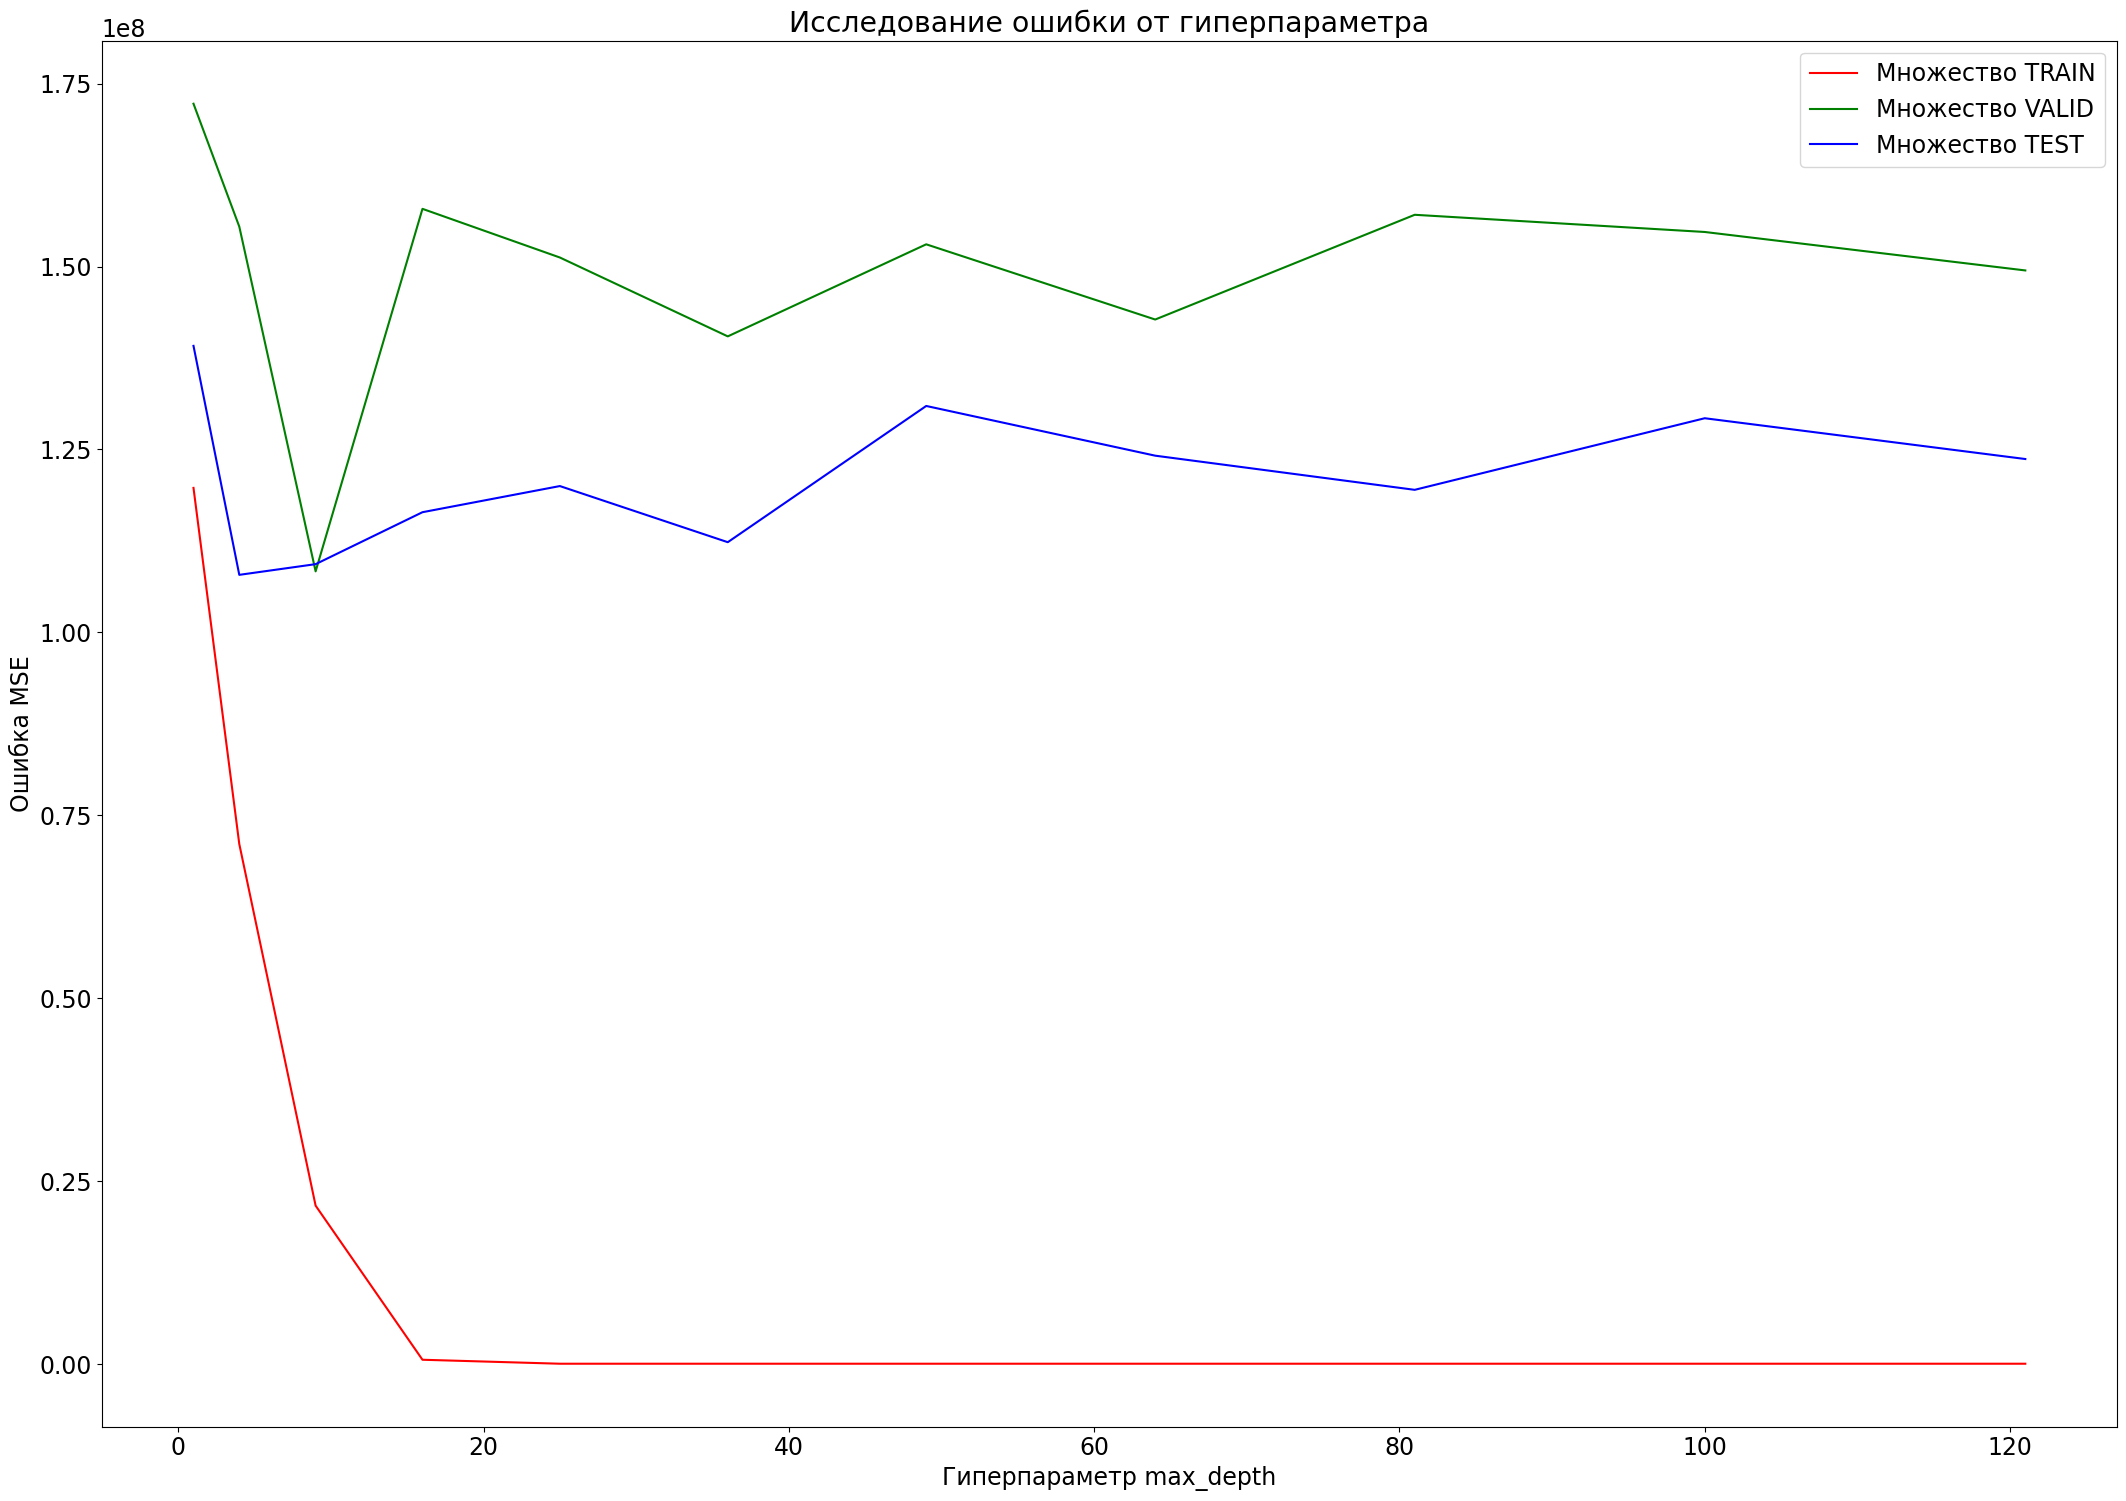

In [59]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

##### Нормализованные данные

In [60]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_scaled(constructor(max_depth = h), msveta_scaled_features_train, msveta_scaled_target_train))
    errors_valid.append(get_errors_scaled(constructor(max_depth = h), msveta_scaled_features_valid, msveta_scaled_target_valid))
    errors_test.append(get_errors_scaled(constructor(max_depth = h), msveta_scaled_features_test, msveta_scaled_target_test))

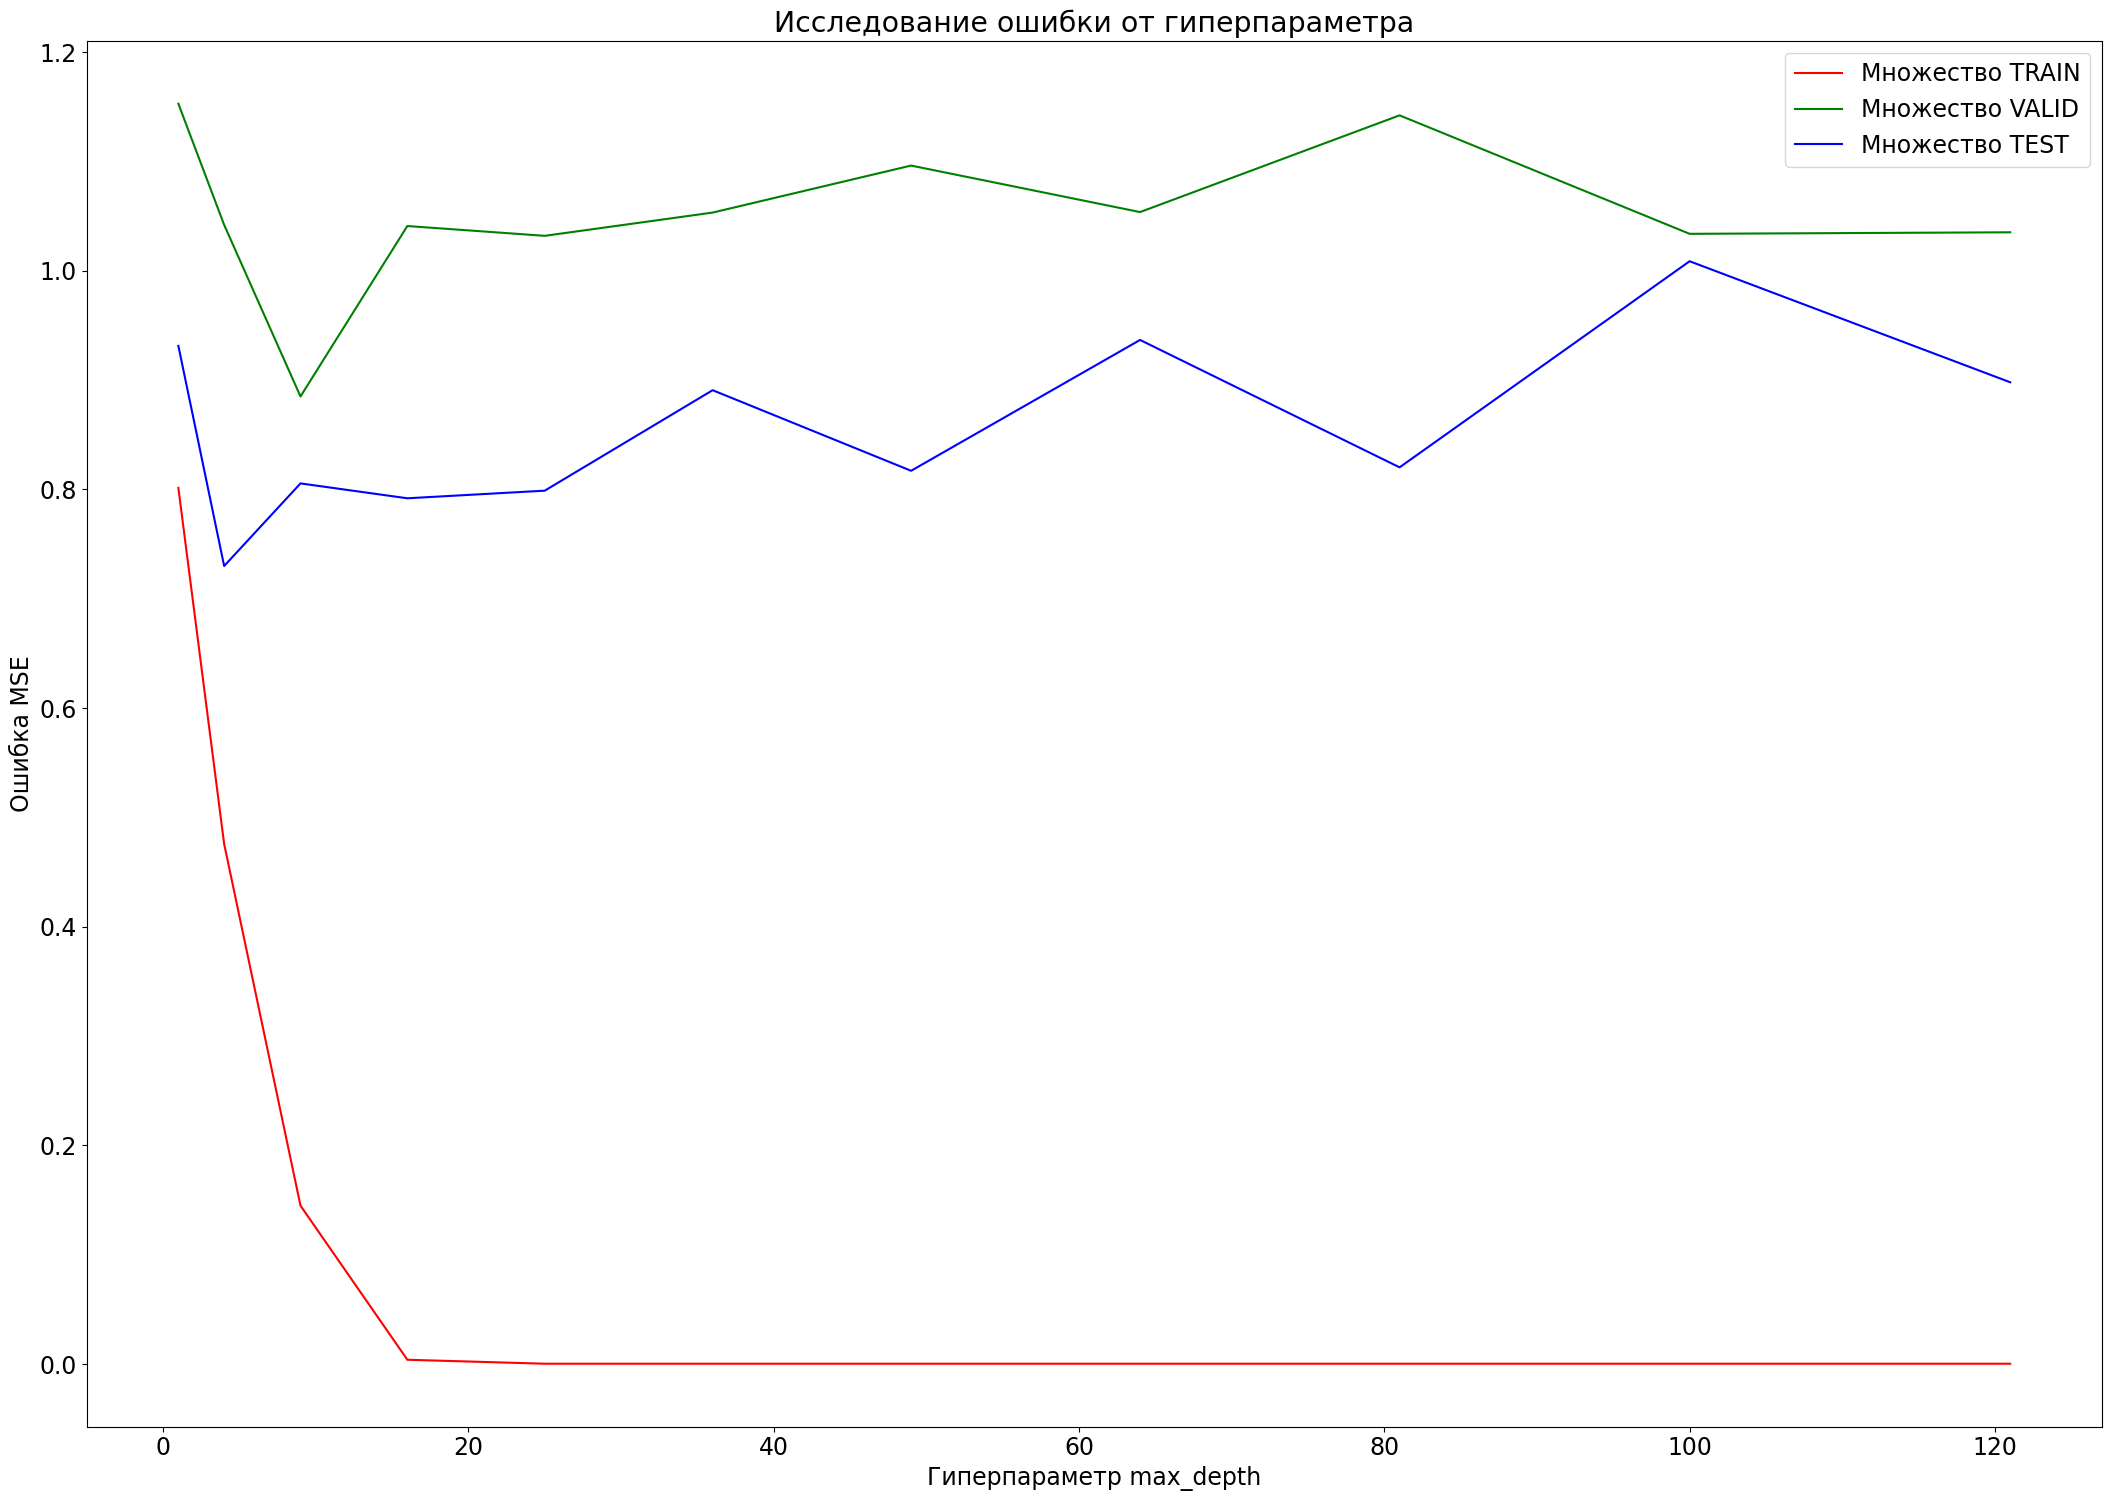

In [61]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

#### Ансамбль

In [62]:
constructor = sklearn.ensemble.RandomForestRegressor
h_params = numpy.arange(1, 12) ** 2
name_param = "n_estimators"

##### Ненормализованные данные

In [63]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_normal(constructor(n_estimators = h), msveta_features_train, msveta_target_train))
    errors_valid.append(get_errors_normal(constructor(n_estimators = h), msveta_features_valid, msveta_target_valid))
    errors_test.append(get_errors_normal(constructor(n_estimators = h), msveta_features_test, msveta_target_test))

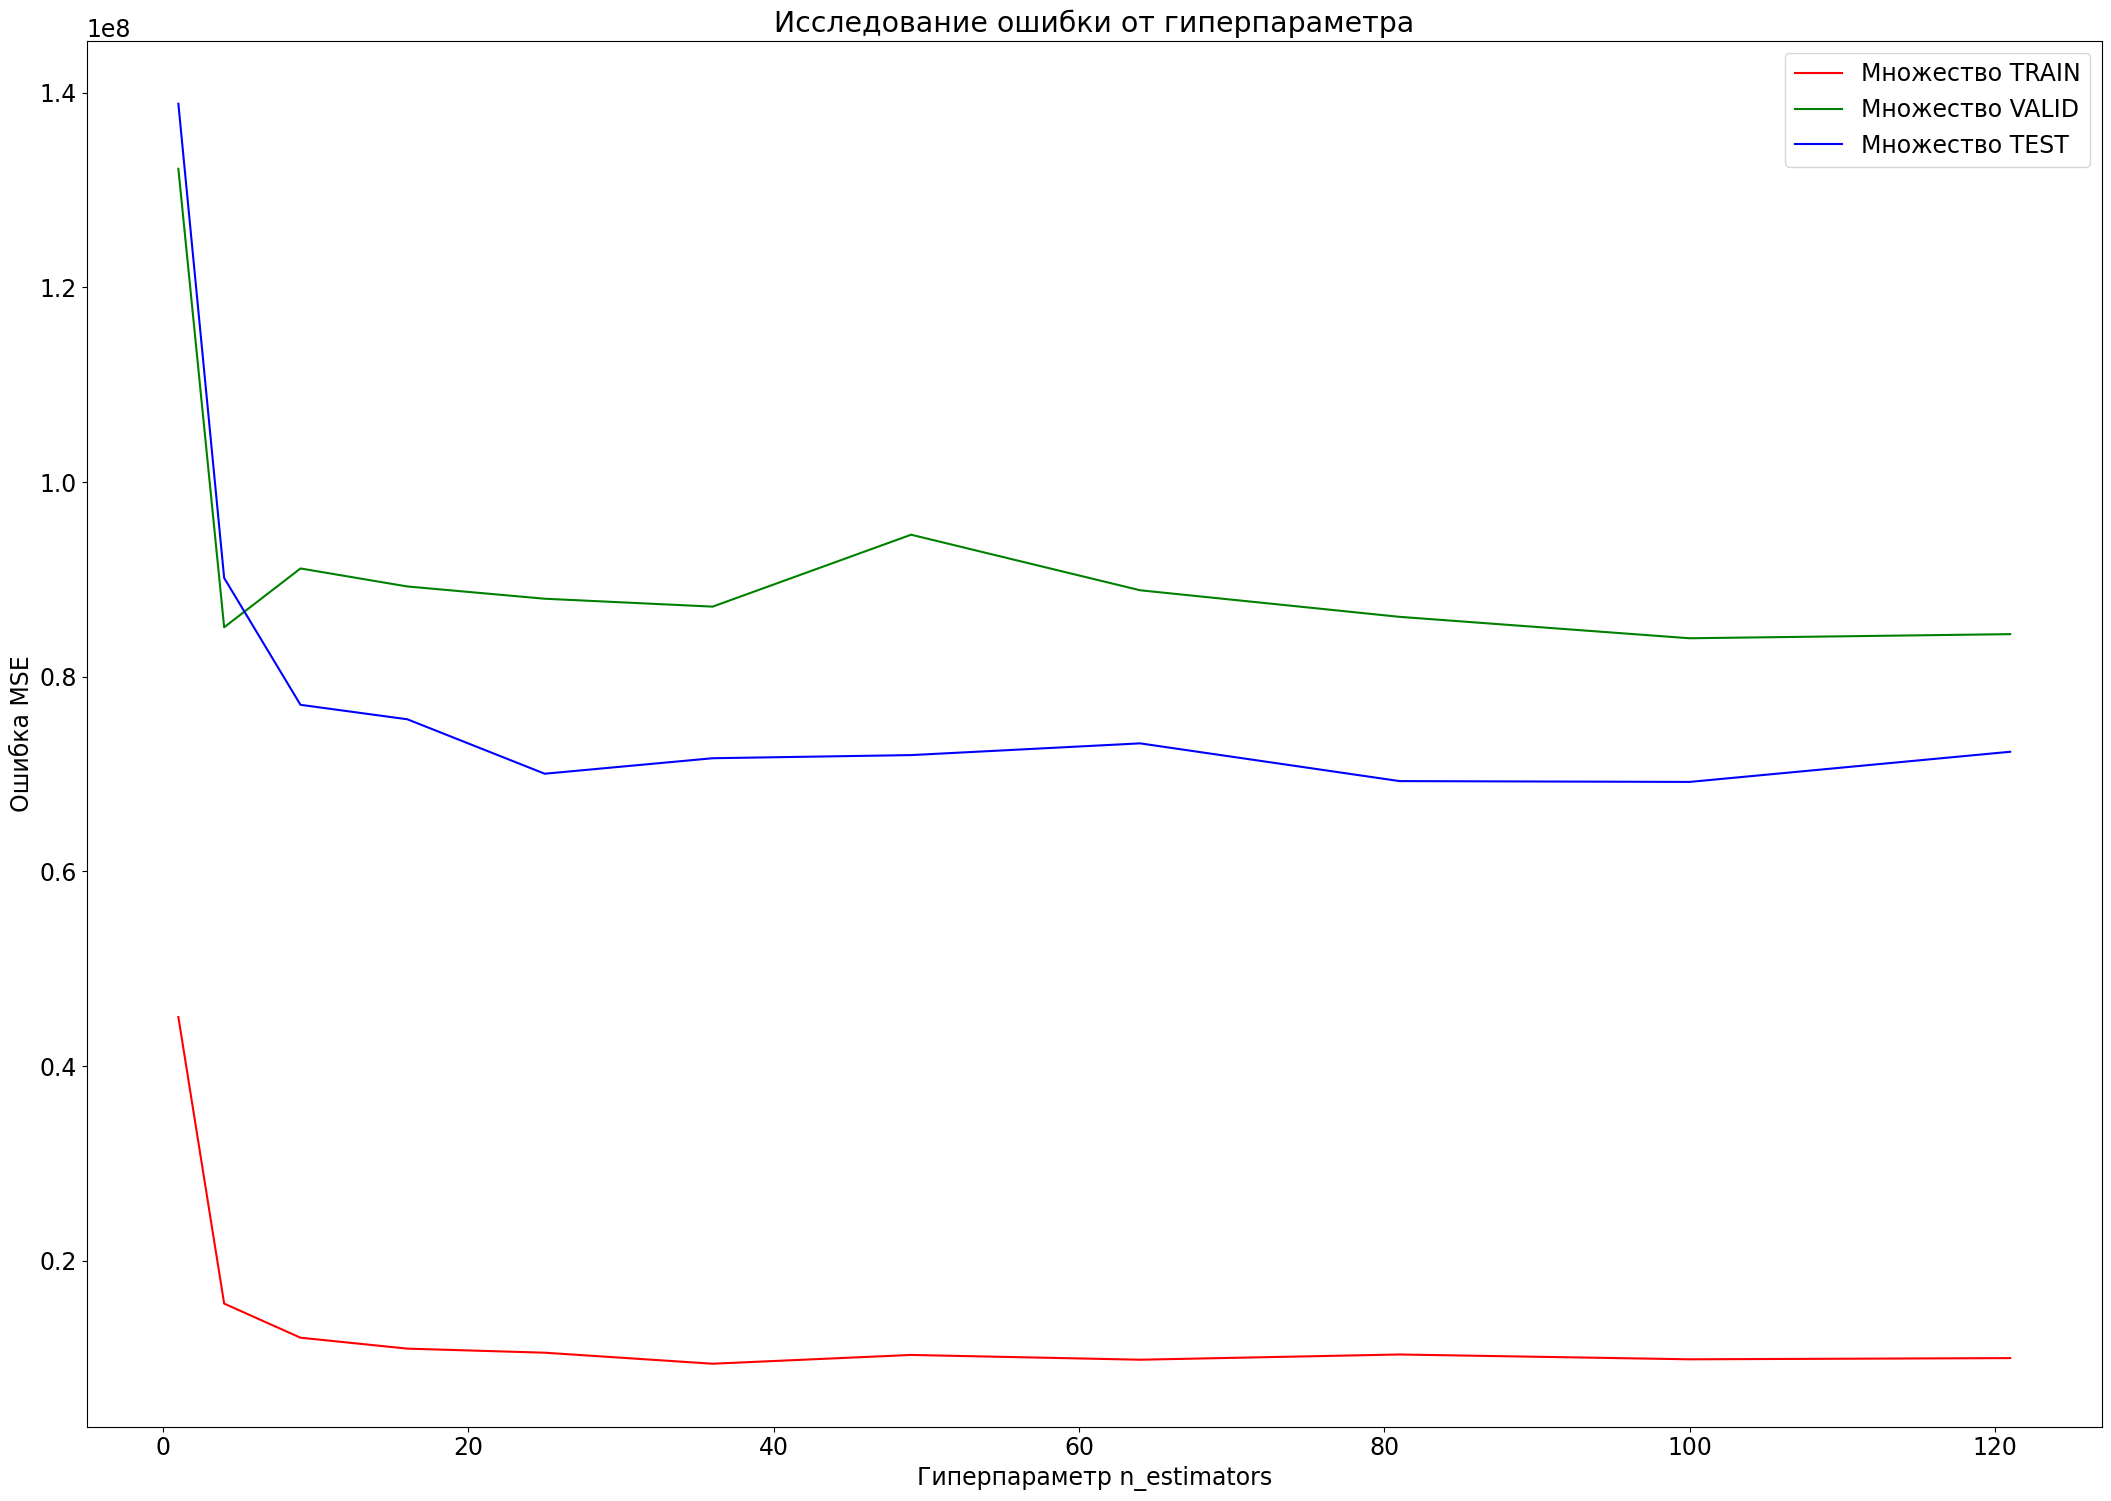

In [64]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)

##### Нормализованные данные

In [65]:
errors_train = []
errors_valid = []
errors_test = []

for h in h_params:
    errors_train.append(get_errors_scaled(constructor(n_estimators = h), msveta_scaled_features_train, msveta_scaled_target_train))
    errors_valid.append(get_errors_scaled(constructor(n_estimators = h), msveta_scaled_features_valid, msveta_scaled_target_valid))
    errors_test.append(get_errors_scaled(constructor(n_estimators = h), msveta_scaled_features_test, msveta_scaled_target_test))

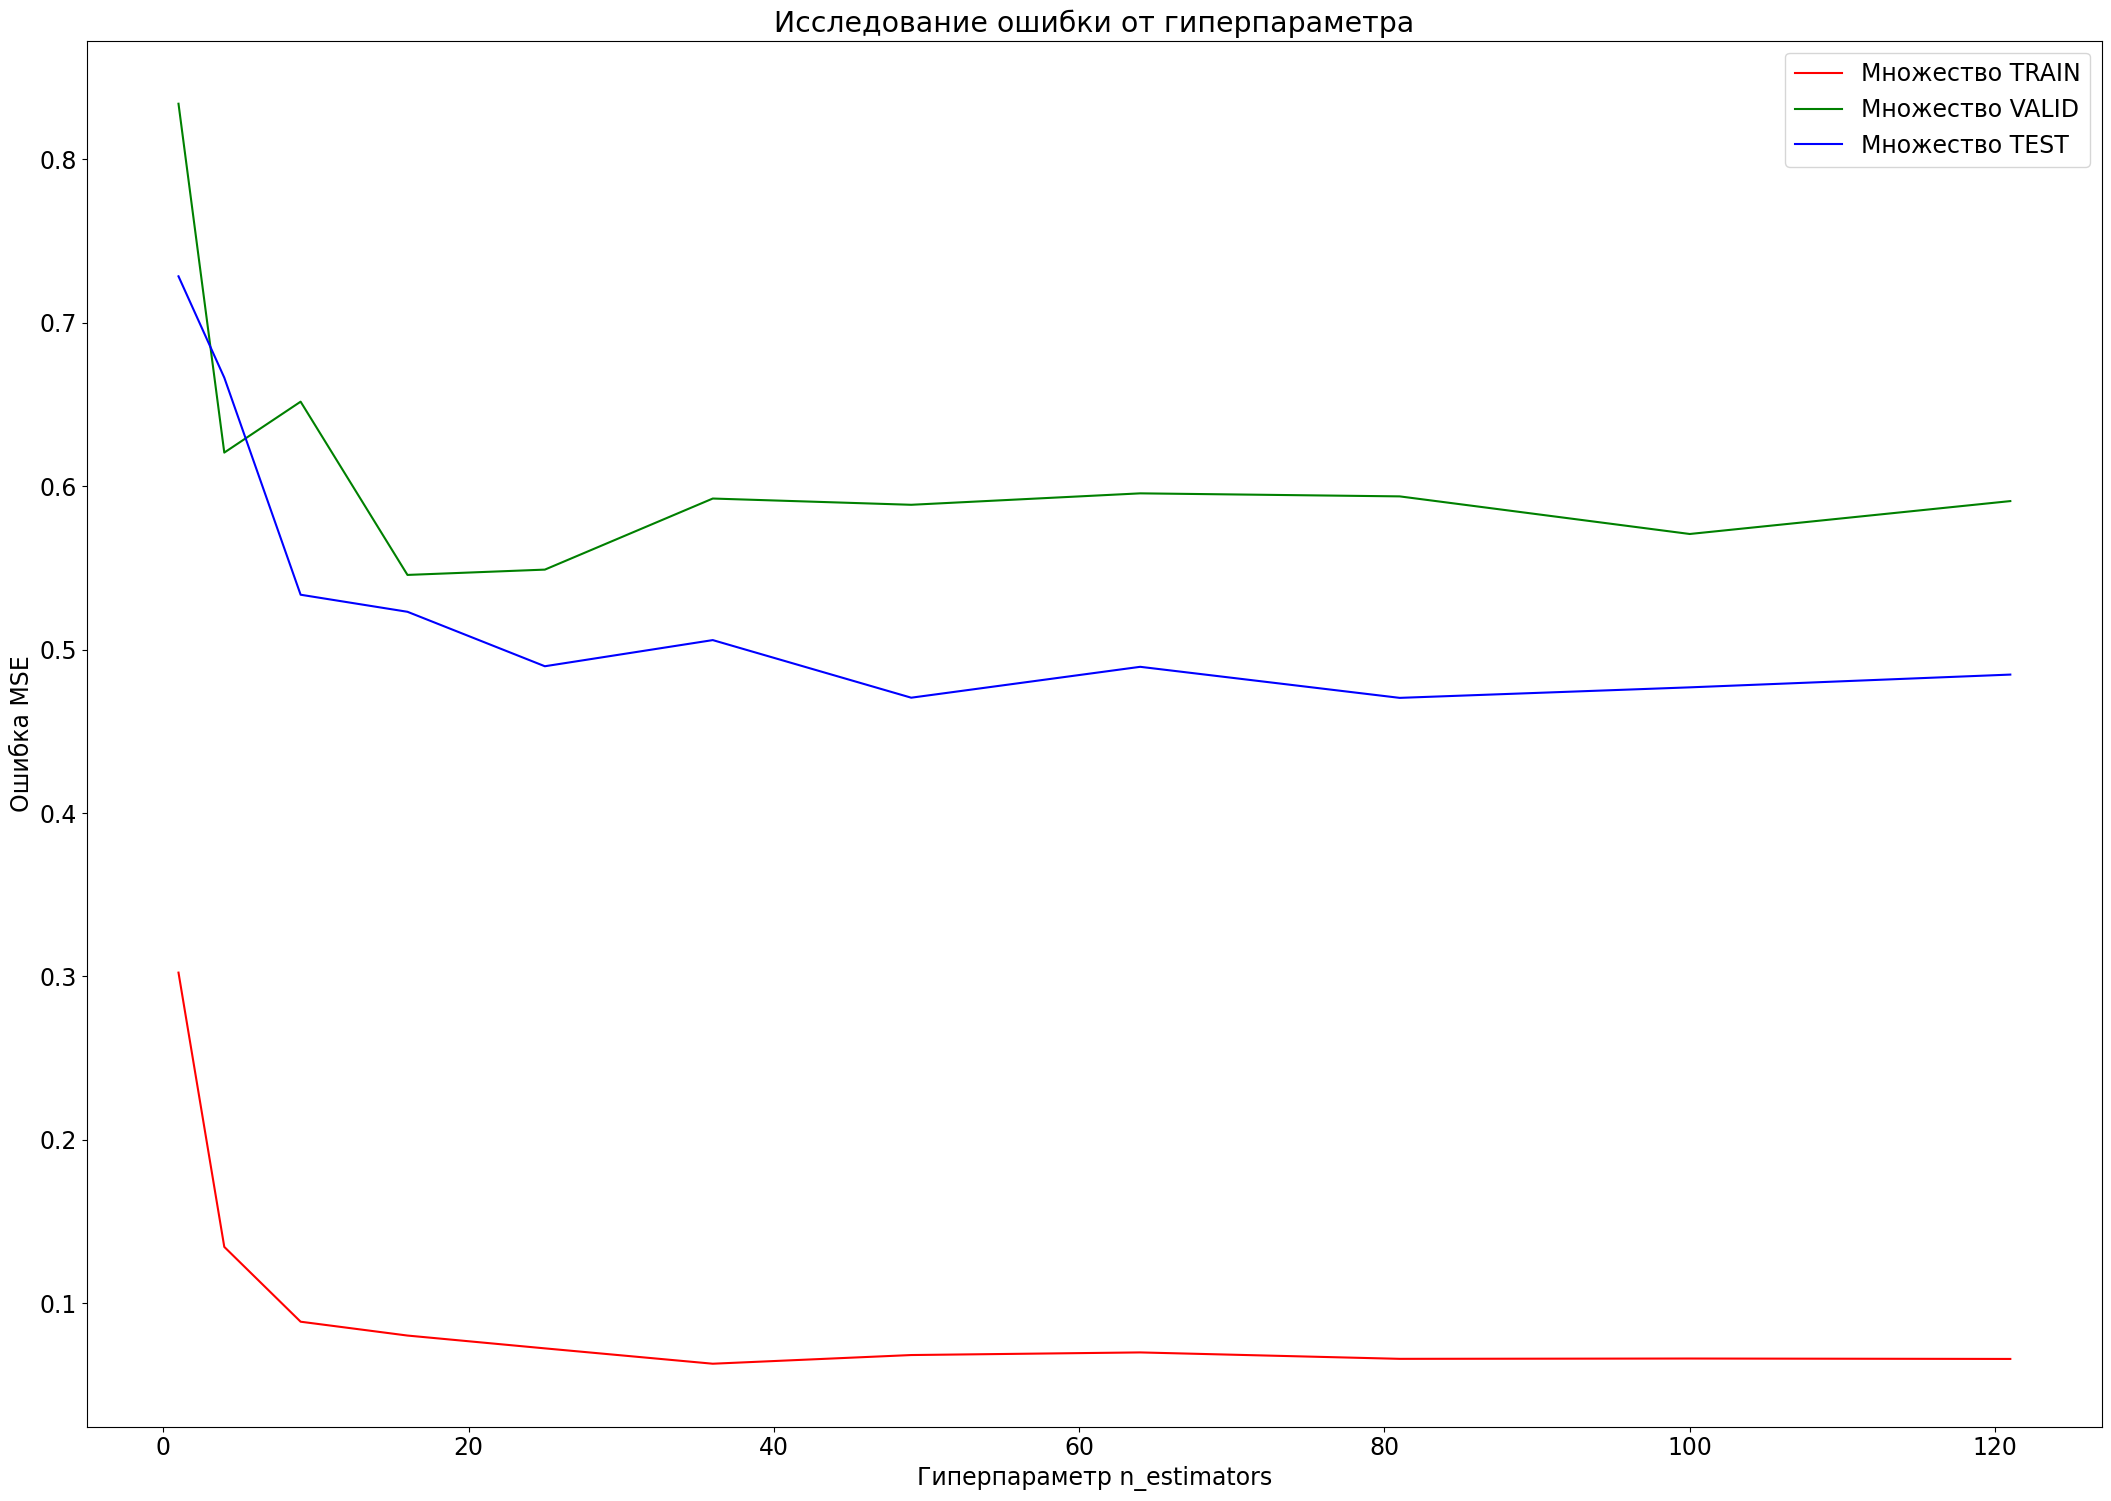

In [66]:
draw_errors(errors_train, errors_valid, errors_test, h_params, name_param)